# Sentiment analysis on news headlines

The goal of this project is to test the hypothesized advantages of using and fine-tuning pre-trained language models of BERT (Bidirectional Encoder Representations from Transformers), which is a 2018 paper published by researchers at Google AI Language, for financial domain. For that, sentiment of a sentence from a financial news article towards the financial actor depicted in the sentence will be tried to be predicted, using the Financial PhraseBank created by Malo et al. from Cornell University. (2014)

<table><tr><td>
<img src="./docs/bert_context.png" width="400">
</td><td>
<img src="./docs/bert_structure2.png" width="600">
</td></tr></table>

<br />
<br />

The models tested in this projects are as follows:
<br />
 * A. Lexicon-based approach (Loughran and McDonald Dictionary)
 * B. Tfidf
 * C. LSTM (RNN)
 * D. LSTM with GloVe word embedding
 * E. Bert (pre-trained, hugging-face impementation)
<br />
<br />
<br />

![All Models](./docs/all_models.png)

## Import and configurations

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [2]:
!pip list

Package                       Version        
----------------------------- ---------------
absl-py                       0.10.0         
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.1.0          
argon2-cffi                   20.1.0         
asgiref                       3.2.10         
astor                         0.8.1          
astropy                       4.0.1.post1    
astunparse                    1.6.3          
async-generator               1.10           
atari-py                      0.2.6          
atomicwrites                  1.4.0          
attrs                         20.2.0         
audioread                     2.1.8          
autograd                      1.3            
Babel                         2.8.0          
backcall                      0.2.0          
beautifulsoup4                4.6.3          
bleach                        3.2.1          
blis                          0.4.

In [3]:
# Note: After the following pip install, need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
if IN_COLAB:
    #!pip install numpy==1.16.4
    #!pip install pandas==0.25.0
    #!pip install torch==1.4.0
    #!pip install tqdm==4.43.0
    !pip install scikit-plot transformers



     |████████████████████████████████| 1.1MB 9.7MB/s 
     |████████████████████████████████| 1.1MB 25.0MB/s 
     |████████████████████████████████| 3.0MB 30.7MB/s 
     |████████████████████████████████| 890kB 36.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=e13d4d586cbb8dbcf101636065120a8c0eb3a7d5044e8093faa3a2b0446d63b0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
import json
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
import torch
# Check GPU Device
if IN_COLAB:
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [6]:
# Set logger
def set_logger(level):
    logger = logging.getLogger('mylogger')
    logger.setLevel(level)

    timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
    formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

    fh = logging.FileHandler('log_model.txt')
    fh.setLevel(logging.DEBUG)
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    # ch = logging.StreamHandler()
    # ch.setLevel(level)
    # ch.setFormatter(formatter)
    # logger.addHandler(ch)

    return logger

logger = set_logger(logging.INFO)

In [7]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
rand_seed = 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [8]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [9]:
# Mount Google Drive
# Enter the oauth code from the link
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Specify file locations
if IN_COLAB:
    finphrase_dir = 'drive/My Drive/Colab Data/'
    tweet_dir = 'drive/My Drive/Colab Data/'
    output_dir = 'drive/My Drive/Colab Data/'
    lmdict_dir = 'drive/My Drive/Colab Data/'
    glove_dir = 'drive/My Drive/Colab Data/'
else:
    finphrase_dir = './data/FinancialPhraseBank-v1.0/'
    tweet_dir = './data/tweet/'
    output_dir = './data/result/'
    lmdict_dir = './data/LoughranMcDonald/'
    glove_dir = './data/GloVe/'

## Evaluation Config

In [11]:
result_df = pd.DataFrame(columns=['Accuracy', 'F1'], index=['A: Lexicon', 'B: Tfidf', 'C1: LSTM', 'C2: LSTM+GloVe', 'D1: BERT', 'D2: ALBERT'])
result_df

,Accuracy,F1
A: Lexicon,NaN,NaN
B: Tfidf,NaN,NaN
C1: LSTM,NaN,NaN
C2: LSTM+GloVe,NaN,NaN
D1: BERT,NaN,NaN
D2: ALBERT,NaN,NaN


### Metrics
As the data are imbalanced, use F1 score (micro) in addition to Accuracy. For cross validation, refit to F1 score.

In [12]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

### Cross validation
Use Stratified KFold because the input data is imbalanced and better to retain the same ratio for cross validation.

In [13]:
kfold = StratifiedKFold(n_splits=7)
kfold

StratifiedKFold(n_splits=7, random_state=None, shuffle=False)

## Load Input Data: Financial Phrasebank Data

Financial Phrasebank ([Malo et al. (2014)](https://www.researchgate.net/publication/251231107_Good_Debt_or_Bad_Debt_Detecting_Semantic_Orientations_in_Economic_Texts)) consists of 4845 english sentences selected randomly from financial news found on LexisNexis database. These sentences then were annotated by 16 people with background in finance and business. The annotators were asked to give labels according to how they think the information in the sentence might affect the mentioned company stock price. The dataset also includes information regarding the agreement levels on sentences among
annotators.

Note: Please make sure to abid by the license and copyright for the use of the data. Please check with the author.

Download the data from this [link](https://www.researchgate.net/profile/Pekka_Malo/publication/251231364_FinancialPhraseBank-v10/data/0c96051eee4fb1d56e000000/FinancialPhraseBank-v10.zip?origin=publication_list) and unzip it under `finphrase_dir` set above.

In [14]:
## Select consensus level for finphrase
# filename = 'Sentences_66Agree.txt'
# filename = 'Sentences_50Agree.txt'
filename = 'Sentences_75Agree.txt'
# filename = 'Sentences_AllAgree.txt'

In [15]:
def load_finphrase(filename):
    ''' Clean FinancialPhrasebank data
        Input:
            - filename
        Output:
            - a dataframe for the loaded financial phase bank data
    '''
    df = pd.read_csv(finphrase_dir + filename,
                     sep='\@',
                     engine='python',
                     header=None,
                     names=['sentence','label'])
    print('Total number of record in the file: ', df.shape[0])
    df.drop_duplicates(inplace=True)
    print('Total number of record after dropping duplicates: ', df.shape[0])
    print('Missing label: ', df['label'].isnull().sum())
    df.reset_index(inplace=True, drop=True)
    # df = pd.get_dummies(df, columns=['label'])
    return df

In [16]:
train_df = load_finphrase(filename)

# Samples
pd.set_option('display.max_colwidth', -1)
train_df.sample(n=20, random_state=42)

Total number of record in the file:  3453
Total number of record after dropping duplicates:  3448
Missing label:  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,sentence,label
2900,"The period-end cash and cash equivalents totaled EUR6 .5 m , compared to EUR10 .5 m in the previous year .",negative
51,"In June it sold a 30 percent stake to Nordstjernan , and the investment group has now taken up the option to acquire EQT 's remaining shares .",neutral
567,The aim is an annual improvement in Ruukki Construction 's operating profit of more than EUR 3 million USD 4.1 m starting in 2009 .,positive
3268,"Sampo Bank 's market share of lending was 13.6 % , down from 14.4 % in the first quarter of 2008 .",negative
1987,"In 2008 , the steel industry accounted for 64 percent of the cargo volumes transported , whereas the energy industry accounted for 28 percent and other industries for 8 percent .",neutral
1873,An earn-out payment of up to 4.0 mln euro ( $ 5.3 mln ) can also be paid depending on Intellibis financial performance in 2007 .,neutral
229,"Profit for the period totaled EUR 39.4 mn , up from EUR 33.9 mn in the corresponding period in 2006 .",positive
298,Operating profit of the Asian plants grew markedly .,positive
605,"Finnish steel maker Rautaruukki Oyj ( Ruukki ) said on July 7 , 2008 that it won a 9.0 mln euro ( $ 14.1 mln ) contract to supply and install steel superstructures for Partihallsforbindelsen bridge project in Gothenburg , western Sweden .",positive
705,The rationalization of the operations seeks to achieve over EUR 1 million in yearly savings as from the second quarter of the current financial year .,positive


In [17]:
# Change the table display config back
pd.set_option('display.max_colwidth', 50)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'The number of words per data')

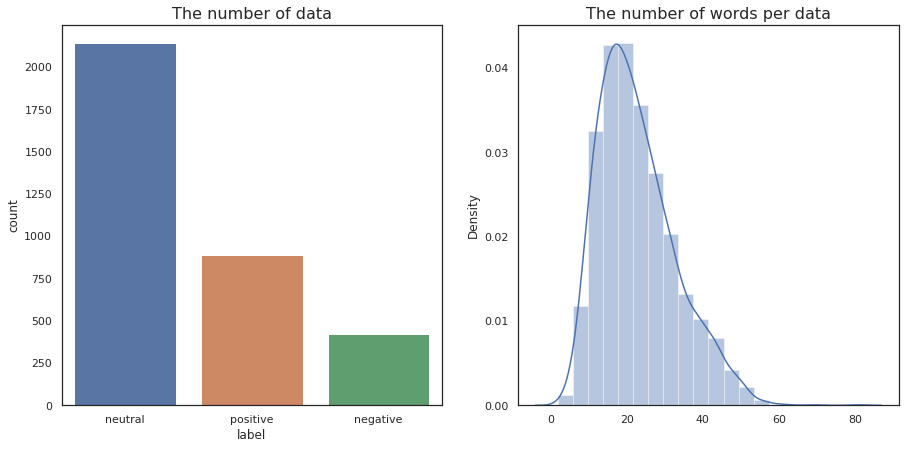

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

sns.countplot(x='label', data=train_df, ax=ax1)
ax1.set_title('The number of data', fontsize=16)
sns.distplot([len(nltk.word_tokenize(words)) for words in train_df['sentence']], bins=20, ax=ax2)
ax2.set_title('The number of words per data', fontsize=16)

More than 60% of the data are labeled as "neutral". Sometimes imbalanced data are balanced using methods like resampling (oversampling, under-sampling) as models tend to predict the majority class more. SMOTE or the Synthetic Minority Over-sampling Technique is a popular technique for oversampling but it is a statistical method for numerical data.

In addition, this imbalance should be also taken into consideration if this happends in the real world. In this case, this can be interpreted as the result of the nature of news, so decided not to resample the data.

## Encode the label

In [19]:
# Encode the label
le = LabelEncoder()
le.fit(train_df['label'])
print(list(le.classes_))
train_df['label'] = le.transform(train_df['label'])
# list(le.inverse_transform(train_df['label']))
train_df['label']

['negative', 'neutral', 'positive']


0       1
1       2
2       2
3       2
4       2
       ..
3443    0
3444    0
3445    0
3446    0
3447    0
Name: label, Length: 3448, dtype: int64

The label is imbalanced and thus better to consider the measurement or balancing the data.

## Explore the text

In [20]:
# Corpus
def create_corpus(df):
    corpus = []
    
    for x in df['sentence'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

# Returns Top X frequent stop words
def get_frequent_stop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

# Returns Top X frequent non stop words
def get_frequent_nonstop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

In [21]:
corpus = create_corpus(train_df)

In [22]:
x, y = get_frequent_stop_words(corpus)

In [23]:
print(x)
print(y)

('the', 'of', 'in', 'and', 'to', 'a', 'for', 'is', 'from', 'will')
(4257, 2311, 2086, 1792, 1706, 1169, 842, 634, 632, 557)


In [24]:
x, y = get_frequent_nonstop_words(corpus)

In [25]:
print(x)
print(y)

('.', ',', 'eur', "'s", 'company', 'mn', 'profit', ')', 'net', '(')
(3389, 3277, 916, 698, 574, 500, 385, 381, 378, 378)


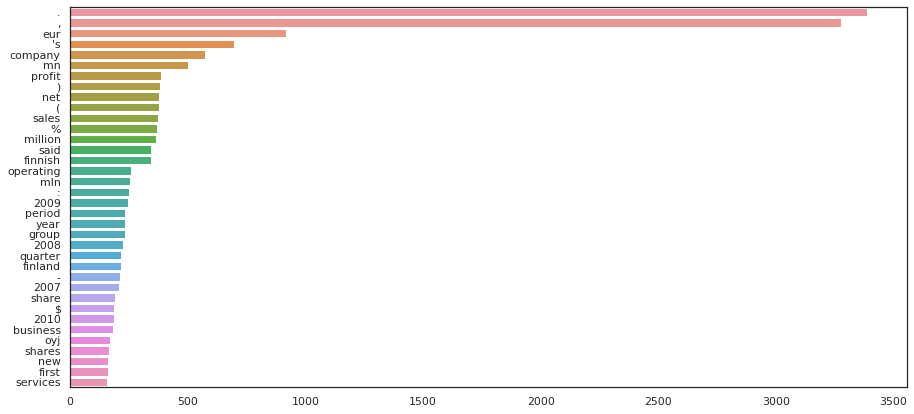

In [26]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus)
most = counter.most_common()[:60]
x, y = [], []
for word, count in most:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,7))
sns.barplot(x=y, y=x)

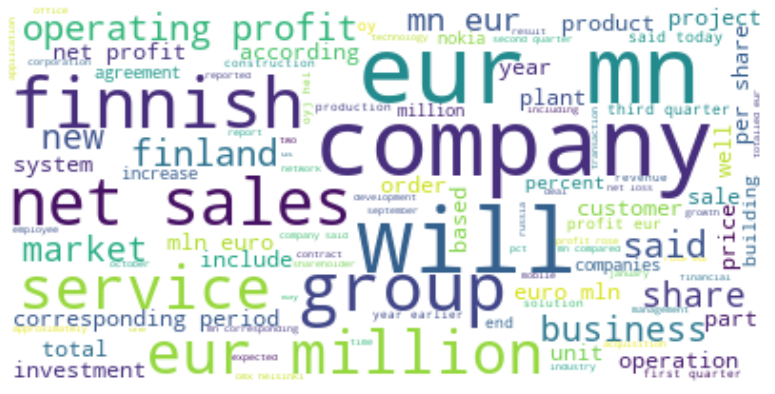

In [27]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create stopword list:
stopwords = set(STOPWORDS)
# stopwords.update(["federal", "federal reserve", "financial", "committee", "market", "would", "also"])

text = " ".join(corpus)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)


# A. Lexicon-based Approach

## Add sentiment based on Loughran and McDonald Sentiment Word Lists

Use [Loughran and McDonald Sentiment Word Lists](https://sraf.nd.edu/textual-analysis/resources/) for sentiment analysis. Use the master word list, combined in two columns (sentiment and word).
<BR /> Note: This data requires the license to use for commercial application. Please check their website.

Download the list and save it under `lmdict_dir` as csv.

In [28]:
# Load sentiment data
sentiment_df = pd.read_csv(lmdict_dir + 'LoughranMcDonald_SentimentWordLists_2018.csv')

print(sentiment_df.shape)
sentiment_df

(4140, 2)


,sentiment,word
0,Negative,ABANDON
1,Negative,ABANDONED
2,Negative,ABANDONING
3,Negative,ABANDONMENT
4,Negative,ABANDONMENTS
...,...,...
4135,Constraining,STRICTER
4136,Constraining,STRICTEST
4137,Constraining,STRICTLY
4138,Constraining,UNAVAILABILITY


In [29]:
# Make all words lower case
sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()

,word
sentiment,
Constraining,184
Litigious,904
Negative,2355
Positive,354
StrongModal,19
Uncertainty,297
WeakModal,27


In [30]:
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

## Analyze the tone with negation without lemmatization

In [31]:
# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [32]:
# Analyze tone for original text dataframe
print(train_df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x.lower()) for x in tqdm(train_df['sentence'], total=train_df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
train_tone_df = pd.concat([train_df, tone_lmdict_df.reindex(train_df.index)], axis=1)
train_tone_df.head()


(3448, 2)


,sentence,label,tone_score,word_count,n_pos_words,n_neg_words,pos_words,neg_words
0,"According to Gran , the company has no plans t...",1,0.000000,22,0,0,[],[]
1,With the new production plant the company woul...,2,6.250000,32,2,0,"[improve, profitability]",[]
2,"For the last quarter of 2010 , Componenta 's n...",2,-2.941176,34,0,1,[],[loss]
3,"In the third quarter of 2010 , net sales incre...",2,0.000000,19,0,0,[],[]
4,Operating profit rose to EUR 13.1 mn from EUR ...,2,0.000000,18,0,0,[],[]


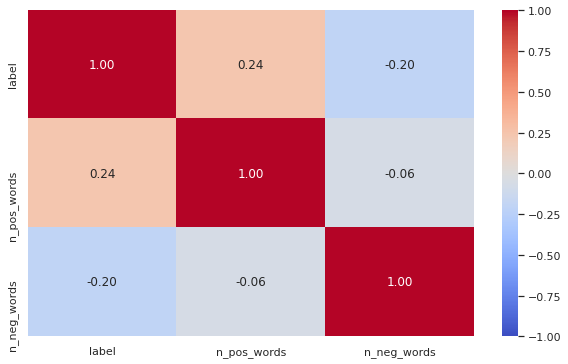

In [33]:
# Show corelations to next_decision
plt.figure(figsize=(10,6))
#corr_columns = ['label', 'tone_score', 'word_count', 'n_pos_words', 'n_neg_words']
corr_columns = ['label', 'n_pos_words', 'n_neg_words']
sns.heatmap(train_tone_df[corr_columns].astype(float).corr(), cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.show()

## Input Data

In [34]:
train_tone_df.columns

Index(['sentence', 'label', 'tone_score', 'word_count', 'n_pos_words',
       'n_neg_words', 'pos_words', 'neg_words'],
      dtype='object')

In [35]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = train_tone_df[['tone_score', 'n_pos_words', 'n_neg_words']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

## Train with different classifier

In [36]:
# Roughly check base classifiers without hyperparameter setting

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC

random_state = 2
classifiers = []
classifiers.append(("SVC", SVC(random_state=random_state)))
classifiers.append(("DecisionTree", DecisionTreeClassifier(random_state=random_state)))
classifiers.append(("AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)))
classifiers.append(("RandomForest", RandomForestClassifier(random_state=random_state, n_estimators=100)))
classifiers.append(("ExtraTrees", ExtraTreesClassifier(random_state=random_state)))
classifiers.append(("GradientBoosting", GradientBoostingClassifier(random_state=random_state)))
classifiers.append(("MultipleLayerPerceptron", MLPClassifier(random_state=random_state)))
classifiers.append(("KNeighboors", KNeighborsClassifier(n_neighbors=3)))
classifiers.append(("LogisticRegression", LogisticRegression(random_state = random_state)))
classifiers.append(("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()))
classifiers.append(("GaussianNB", GaussianNB()))
classifiers.append(("Perceptron", Perceptron()))
classifiers.append(("LinearSVC", LinearSVC()))
classifiers.append(("SGD", SGDClassifier()))

classifiers

[('SVC',
  SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, probability=False, random_state=2, shrinking=True, tol=0.001,
      verbose=False)),
 ('DecisionTree',
  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=2, splitter='best')),
 ('AdaBoost', AdaBoostClassifier(algorithm='SAMME.R',
                     base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                           class_weight=None,
                                                           criterion='gi

In [37]:
pd.DataFrame([rec[0] for rec in classifiers])

,0
0,SVC
1,DecisionTree
2,AdaBoost
3,RandomForest
4,ExtraTrees
5,GradientBoosting
6,MultipleLayerPerceptron
7,KNeighboors
8,LogisticRegression
9,LinearDiscriminantAnalysis


In [38]:
cv_results = []
classifier_name = []
for classifier in classifiers :
    cv_results.append(cross_validate(classifier[1], X_train, y = Y_train, scoring = ["accuracy", "f1_macro"], cv = kfold, n_jobs=4))
    classifier_name.append(classifier[0])

cv_acc_means = []
cv_acc_std = []
cv_f1_means = []
cv_f1_std = []
for cv_result in cv_results:
    cv_acc_means.append(cv_result['test_accuracy'].mean())
    cv_acc_std.append(cv_result['test_accuracy'].std())
    cv_f1_means.append(cv_result['test_f1_macro'].mean())
    cv_f1_std.append(cv_result['test_f1_macro'].std())

cv_res = pd.DataFrame({"Algorithm": classifier_name,
                       "CVAccMeans":cv_acc_means,
                       "CVAccErrors": cv_acc_std,
                       "CVf1Means":cv_f1_means,
                       "CVf1Errors": cv_f1_std})

cv_res.sort_values(by='CVAccMeans', ascending=False)

,Algorithm,CVAccMeans,CVAccErrors,CVf1Means,CVf1Errors
9,LinearDiscriminantAnalysis,0.662799,0.005664,0.513278,0.011052
12,LinearSVC,0.662799,0.015962,0.463403,0.036239
8,LogisticRegression,0.662437,0.016393,0.459665,0.038314
6,MultipleLayerPerceptron,0.660986,0.008236,0.489961,0.034049
11,Perceptron,0.658811,0.014853,0.475113,0.062233
10,GaussianNB,0.656635,0.006024,0.512075,0.015680
0,SVC,0.654460,0.009729,0.491030,0.019423
13,SGD,0.650834,0.025843,0.414219,0.060748
5,GradientBoosting,0.650109,0.011704,0.458950,0.026442
7,KNeighboors,0.649746,0.006217,0.459814,0.015643


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Cross validation scores')

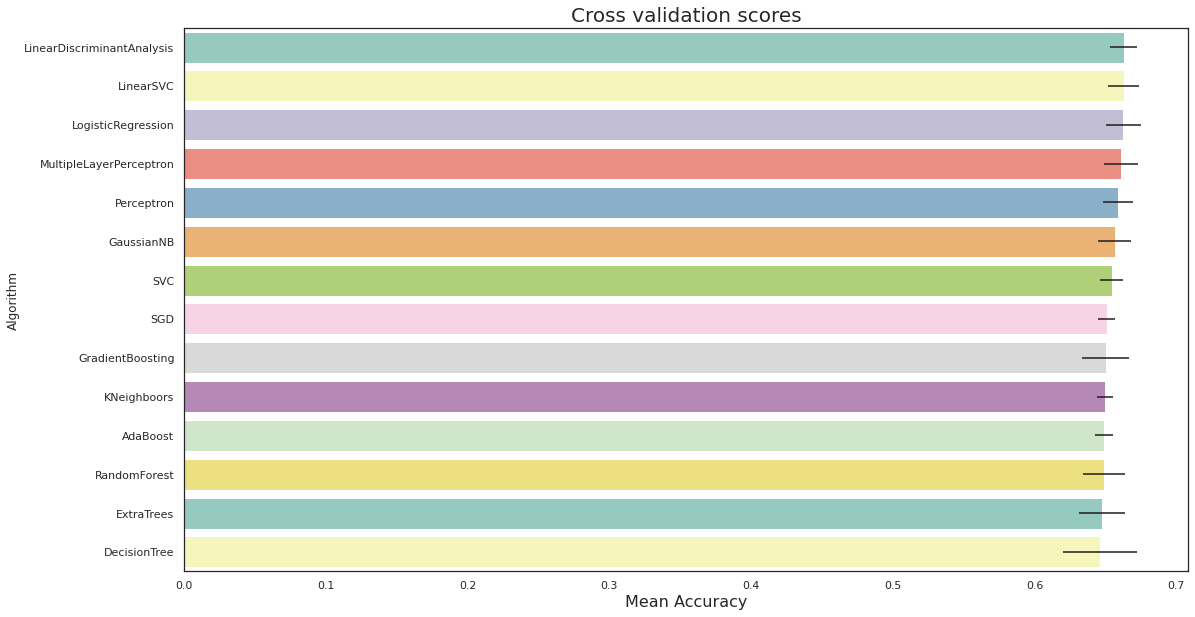

In [39]:
# Accuracy Score Graph
plt.figure(figsize=(18,10))
ax = sns.barplot("CVAccMeans","Algorithm",data=cv_res.sort_values(by='CVAccMeans', ascending=False), palette="Set3", orient="h", **{'xerr':cv_acc_std})
ax.set_xlabel("Mean Accuracy", size=16)
ax.set_title("Cross validation scores", size=20)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Cross validation scores')

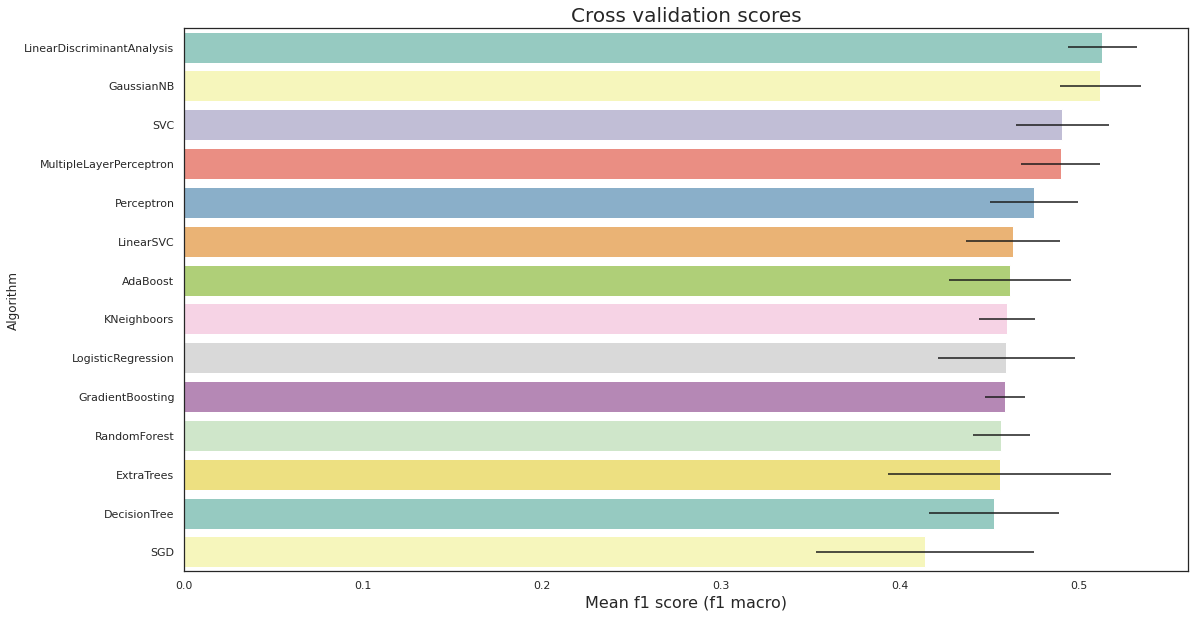

In [40]:
# F1 Score Graph
plt.figure(figsize=(18,10))
ax = sns.barplot("CVf1Means","Algorithm",data=cv_res.sort_values(by='CVf1Means', ascending=False), palette="Set3", orient="h", **{'xerr':cv_f1_std})
ax.set_xlabel("Mean f1 score (f1 macro)", size=16)
ax.set_title("Cross validation scores", size=20)

## Train with Grid Search Cross Validation

In [41]:
# Train and visualisation Function

def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Negative', 'Neutral', 'Positive']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


Fitting 7 folds for each of 480 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 1500 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed:  2.4min finished


Best Score:  0.4799622887975746
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1}


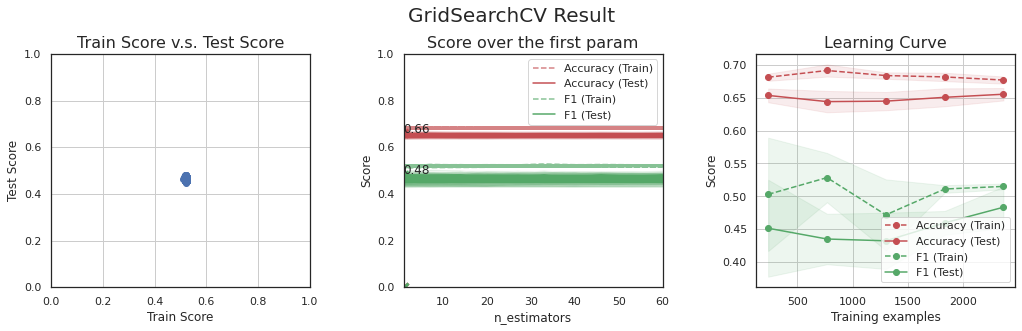

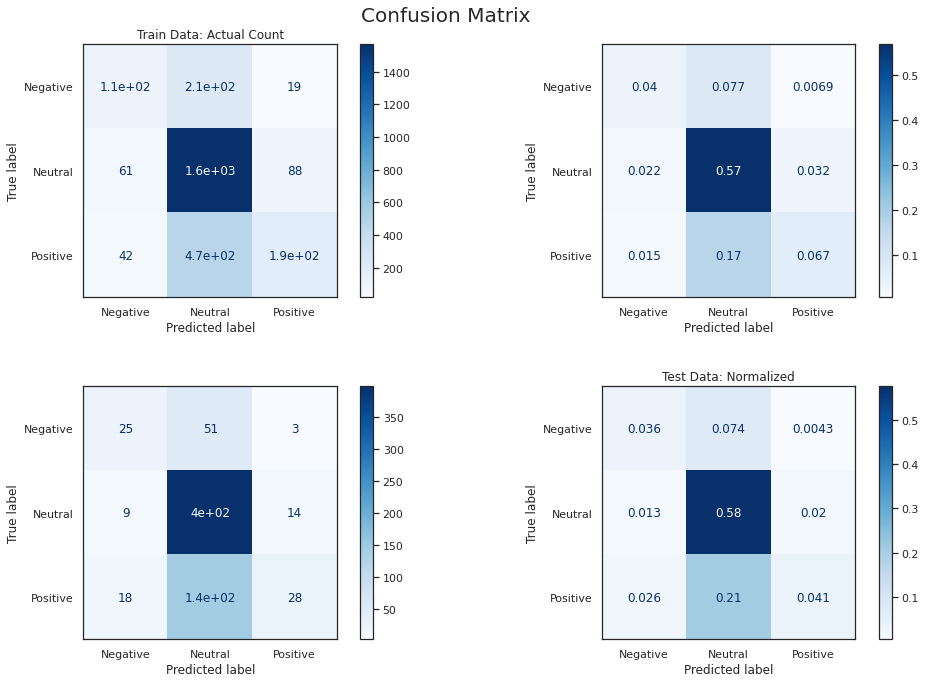

In [42]:
# Use Random Forest Classifier
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [1, 3, 5, 10],
              'min_samples_leaf': [1, 2, 3, 5],
              'max_features': [1, 2, 3],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

## Result
The prediction is not good at all. Hyper parameter tuning of Random Forest could not beat the simple model of Linear Discriminant Analysis. 
Confusion matrix shows almost all the data have been labeled as "neutral", the majority class.

In [43]:
pred_test = rf_best.predict(X_test)
acc, f1 = metric(Y_test, pred_test)
result_df.loc['A: Lexicon'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,F1
A: Lexicon,0.6536,0.4683
B: Tfidf,NaN,NaN
C1: LSTM,NaN,NaN
C2: LSTM+GloVe,NaN,NaN
D1: BERT,NaN,NaN
D2: ALBERT,NaN,NaN


Text(0.5, 1.0, 'Feature importance')

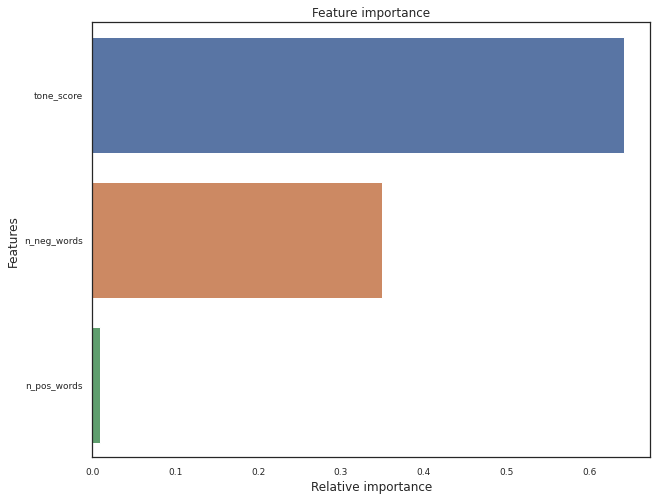

In [44]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10,8))

indices = np.argsort(rf_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=rf_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance")


# B. Tfidf

### Tokenizer

In [45]:
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    Mode:
        1: NLTK word_tokenize(), Stop words removal, Alphabet only, Lemmetize
        2: NLTK word_tokenize(), Stop words removal, Alphabet only, Do not lemmetize
        3: NLTK word_tokenize(), Do not remove stop words, Alphabet only, Do not lemmetize
        4: (alphabet + "'s" + "'t")

    '''
    tokenized = []
    for text in tqdm(df[col]):
        # Filter alphabet words only , make it loser case
        if tokenizer=='NLTK':
            words = [word.lower() for word in word_tokenize(text) if (word.isalpha()==1)]
        else:
            words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text.lower())

        # Remove stop words
        if stopwords:
             words = [word for word in words if (word not in stop)]
        # Lemmatize words
        if lemma:
            tokens = [lemmatize_word(word) for word in words]
            tokenized.append(tokens)
        else:
            tokenized.append(words)

    # Concat the list to create docs
    tokenized_text = [" ".join(words) for words in tokenized]

    # Create a list of all the words in the dataframe
    all_words = [word for text in tokenized for word in text]

    # Counter object of all the words
    counts = Counter(all_words)

    # Create a Bag of Word, sorted by the count of words
    bow = sorted(counts, key=counts.get, reverse=True)

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    # Create token id list
    token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]

    return tokenized, tokenized_text, bow, vocab, id2vocab, token_ids


In [46]:
# Lemmatize sentiment (not used)

# # pd.get_dummies(sentiment_df, prefix=None, dtype=bool)
# # sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# # Lemmertize sentiment words as well
# lemma_sentiment_df = sentiment_df.copy(deep=True)
# lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# # Drop duplicates
# lemma_sentiment_df = sentiment_df.drop_duplicates('word')
# # Sentiment list
# lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

# lemma_sentiment_df.groupby(by=['sentiment']).count()

## Tokenise input texts

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


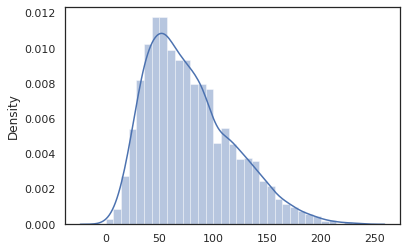

In [47]:
# Tokenize
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_tone_df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK')
sns.distplot([len(x) for x in tokenized_text])


In [48]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = tokenized_text

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data, Y_data.values, test_size=0.2, shuffle=True)

## Model and Train (Logistic Regression)


In [49]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', LogisticRegression())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

## Model and Train (Random Forest)

In [50]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

Fitting 7 folds for each of 20 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  1.8min finished


Best Score:  0.7178570800790327
Best Param:  {'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 6, 'clf__n_estimators': 50}


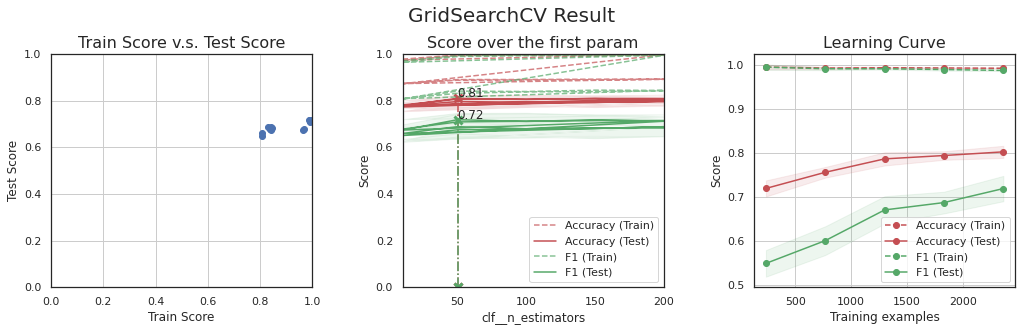

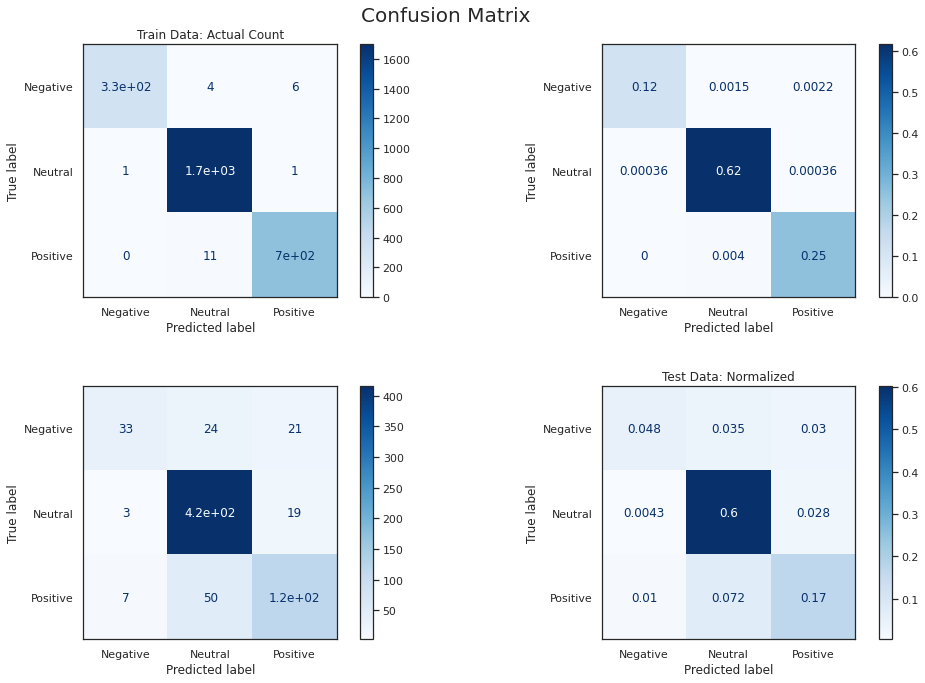

In [51]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

# Perform Grid Search
param_grid = {'clf__n_estimators': [10, 50, 100, 150, 200],
              'clf__min_samples_leaf': [1, 2],
              'clf__min_samples_split': [4, 6],
              'clf__max_features': ['auto']
             }

tfidf_model = train_grid_search(pipeline, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
tfidf_best = tfidf_model.best_estimator_

## Result
Much better than lexicon approach. Apparently it overfitting to the training set.

In [52]:
pred_test = tfidf_best.predict(X_test)
acc, f1 = metric(Y_test, pred_test)
result_df.loc['B: Tfidf'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,F1
A: Lexicon,0.6536,0.4683
B: Tfidf,0.8203,0.7163
C1: LSTM,NaN,NaN
C2: LSTM+GloVe,NaN,NaN
D1: BERT,NaN,NaN
D2: ALBERT,NaN,NaN


# C1. LSTM (RNN)
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

<table><tr><td><img src="./docs/lstm_4.png" width=450></td><td><img src="./docs/lstm_1.png" width=300></td></tr></table>


In [53]:
# Import Pytorch modules
# import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam, AdamW

### Tokenise input texts

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


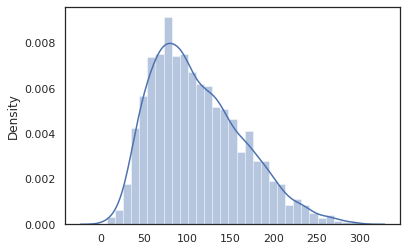

In [54]:
# Tokenize
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_tone_df, col='sentence', lemma=False, stopwords=False, tokenizer='Own')
sns.distplot([len(x) for x in tokenized_text])


In [55]:
# # Split data into training and validation datasets. Use an appropriate split size.

# split_frac = 0.8

# split_idx = int(len(token_ids)*split_frac)

# train_features = token_ids[:split_idx]
# valid_features = token_ids[split_idx:]
# train_labels = Y_data[:split_idx]
# valid_labels = Y_data[split_idx:]

# print("len(token_ids): ", len(token_ids))
# print("len(train_features): ", len(train_features))
# print("len(valid_features): ", len(valid_features))
# print("len(train_labels): ", len(train_labels))
# print("len(valid_labels): ", len(valid_labels))

# X and Y data used
y_data = train_tone_df['label']
X_data = token_ids

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, y_train, y_test = \
model_selection.train_test_split(X_data, y_data.values, test_size=0.2, shuffle=True)

### Define Model
#### Embed -> RNN -> Dense -> Softmax

In [56]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, dense_size, output_size, lstm_layers=2, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.dense_size = dense_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(dropout)

        if dense_size == 0:
            self.fc = nn.Linear(lstm_size, output_size)
        else:
            self.fc1 = nn.Linear(lstm_size, dense_size)
            self.fc2 = nn.Linear(dense_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """

        weight = next(self.parameters()).data
        # print('initial weight size: ', weight.shape)
        # print('initial weight: ', weight)
        # print('initial weight new: ', weight.new(self.lstm_layers, batch_size, self.lstm_size))

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        if self.dense_size == 0:
            out = self.fc(lstm_out)
        else:
            dense_out = self.fc1(lstm_out)
            out = self.fc2(dense_out)
        # Softmax
        logps = self.softmax(out)

        return logps, hidden_state

### DataLoaders and Batching

Here, I used own dataloader. It's also fine to use tensorflow/keras or pytorch implementation.

In [57]:
def dataloader(messages, labels, sequence_length=200, batch_size=16, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

In [58]:
# Test the model
text_batch, labels = next(iter(dataloader(X_train, y_train)))
lstm_model = TextClassifier(len(vocab), 512, 128, 8, 3)
hidden = lstm_model.init_hidden(16)
logps, hidden = lstm_model.forward(text_batch, hidden)
print(logps)

tensor([[-0.9451, -1.2771, -1.1011],
        [-0.9280, -1.2896, -1.1109],
        [-0.9530, -1.2285, -1.1341],
        [-0.9610, -1.2582, -1.0986],
        [-0.9428, -1.2767, -1.1041],
        [-0.9435, -1.2763, -1.1036],
        [-0.9309, -1.2558, -1.1364],
        [-0.9508, -1.2649, -1.1047],
        [-0.9627, -1.2363, -1.1158],
        [-0.9453, -1.2644, -1.1116],
        [-0.9283, -1.2929, -1.1078],
        [-0.9627, -1.2676, -1.0888],
        [-0.9386, -1.2710, -1.1139],
        [-0.9449, -1.2707, -1.1067],
        [-0.9402, -1.2603, -1.1212],
        [-0.9390, -1.2619, -1.1213]], grad_fn=<LogSoftmaxBackward>)


### Configure the model and train!

In [59]:
# Define the training process

def train_lstm_model(lstm_model, X_train, y_train, X_valid, y_valid, epochs, batch_size, learning_rate, sequence_length, patience, clip, print_every, print_epoch):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize Model
    lstm_model.embedding.weight.data.uniform_(-1, 1)
    lstm_model.to(device)

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    lstm_model.train()

    # Initialise
    accuracy = []
    f1_score = []
    best_f1, early_stop = 0, 0
    
    class_names = ['Negative', 'Neutral', 'Positive']


    # Validation steup
    def do_vadalition(valid_hidden):
        lstm_model.eval()
        valid_losses = []
        y_predicted = []
        y_truth = []
        # valid_hidden = lstm_model.init_hidden(batch_size)

        for text_batch, labels in dataloader(
                X_valid, y_valid, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):

            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Initialize within the loop to use label shape if batch_size did not work
            # valid_hidden = lstm_model.init_hidden(labels.shape[0])

            # Creating new variables for the hidden state
            valid_hidden = tuple([each.data for each in valid_hidden])

            # Set Device
            text_batch, labels = text_batch.to(device), labels.to(device)
            for each in valid_hidden:
                each.to(device)

            # Get output and hidden state from the model
            valid_output, _ = lstm_model(text_batch, valid_hidden)

            # Calculate the loss     
            valid_loss = criterion(valid_output.squeeze(), labels)
            valid_losses.append(valid_loss.item())

            # Prediction
            ps = torch.exp(valid_output)
            top_p, top_class = ps.topk(1, dim=1)
            # equals = top_class == labels.view(*top_class.shape)
            # accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

            y_predicted.extend(top_class.squeeze().cpu().numpy())
            y_truth.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())

        lstm_model.train()

        return y_truth, y_predicted, valid_losses

    # Training cycle
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # print('Starting epoch {}'.format(epoch + 1))
        hidden = lstm_model.init_hidden(batch_size)
        steps = 0

        for text_batch, labels in dataloader(
                X_train, y_train, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
            steps += 1
            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Creating new variables for the hidden state to avoid backprop entire training history
            hidden = tuple([each.data for each in hidden])
        
            # Set Device
            text_batch, labels = text_batch.to(device), labels.to(device)
            for each in hidden:
                each.to(device)
        
            # optimizer.zero_grad()
            lstm_model.zero_grad()
        
            # Get output and hidden state from the model
            output, hidden = lstm_model(text_batch, hidden)

            # Calculate the loss and perform backprop
            loss = criterion(output, labels)
            loss.backward()

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(lstm_model.parameters(), clip)

            # Optimize
            optimizer.step()

            if steps % print_every == 0:
                y_truth, y_predicted, valid_losses = do_vadalition(hidden)
                acc, f1 = metric(y_truth, y_predicted)
                print("Epoch: {}/{}".format(epoch+1, epochs),
                      "Step: {}...".format(steps),
                      "Loss: {:.6f}".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                      "Accuracy: {:.6f}".format(acc),
                      "F1 Score: {:.6f}".format(f1))

        # End of epoch evaluation
        y_truth, y_predicted, valid_losses = do_vadalition(hidden)
        acc, f1 = metric(y_truth, y_predicted)
        
        if print_epoch:
            print("Completed {} steps in epoch {}".format(steps, epoch+1))
            

            # Plot Confusion Matrix
            y_truth_class = [class_names[int(idx)] for idx in y_truth]
            y_predicted_class = [class_names[int(idx)] for idx in y_predicted]
            
            titles_options = [("Actual Count", None), ("Normalised", 'true')]
            for title, normalize in titles_options:
                disp = skplt.metrics.plot_confusion_matrix(y_truth_class, y_predicted_class, normalize=normalize, title=title)
            plt.show()

            print("\nEpoch: %d, Accuracy: %.8f, F1: %.8f\n" % (epoch+1, acc, f1))

        # If not improving, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
        else:
            early_stop += 1
                
        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

    # Post process
    y_truth, y_predicted, valid_losses = do_vadalition(hidden)
    acc, f1 = metric(y_truth, y_predicted)
    print("Completed all epochs")
    print("Accuracy: %.8f, F1: %.8f" % (acc, f1))

    return acc, f1

In [60]:
# Set Hyperparameters

# for Training
epochs=15
batch_size=64
learning_rate=3e-4
sequence_length=48
dropout=0.1
patience=5
clip=5
print_every=1000
print_epoch=False

# Model parameters
embed_size=512
lstm_size=128
dense_size=0
lstm_layers=2

In [61]:
# Use SKF for training
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_list = []
f1_list = []
  
for fold, (train_indices, valid_indices) in enumerate(skf.split(y_train, y_train)):
    print("########## STARTING FOLD {} ##########".format(fold+1))
    # Split to train set and validation set
    X_train_fold = np.array(X_train)[train_indices]
    y_train_fold = y_train[train_indices]
    X_valid_fold = np.array(X_train)[valid_indices]
    y_valid_fold = y_train[valid_indices]

    # Set Model
    model = TextClassifier(len(vocab)+1, embed_size, lstm_size, dense_size, 3, lstm_layers, dropout)

    # Train the model for this fold
    acc, f1 = train_lstm_model(model, X_train_fold, y_train_fold, X_valid_fold, y_valid_fold, \
                                epochs, batch_size, learning_rate, sequence_length, \
                                patience, clip, print_every, print_epoch)

    acc_list.append(acc)
    f1_list.append(f1)

print("#################### FINAL RESULT ####################")

avg_acc = np.mean(acc_list)
avg_f1 = np.mean(f1_list)

print("Average Accuracy: %.8f, Average F1: %.8f" % (avg_acc, avg_f1))

# Save the best model
# torch.save(best_lstm_model.state_dict(), output_dir + 'finphrase_lstm_model_f{}_e{}.dict'.format(best_fold, best_epoch))

########## STARTING FOLD 1 ##########



Completed all epochs
Accuracy: 0.82812500, F1: 0.78295640
########## STARTING FOLD 2 ##########



Completed all epochs
Accuracy: 0.81250000, F1: 0.73909778
########## STARTING FOLD 3 ##########



Completed all epochs
Accuracy: 0.79492188, F1: 0.73898181
########## STARTING FOLD 4 ##########


Completed all epochs
Accuracy: 0.80859375, F1: 0.75108515
########## STARTING FOLD 5 ##########



Completed all epochs
Accuracy: 0.77734375, F1: 0.69330675
#################### FINAL RESULT ####################
Average Accuracy: 0.80429688, Average F1: 0.74108558


## Result

In [62]:
# Re-train the model with all Train set and validate on Test set
acc, f1 = train_lstm_model(model, X_train, y_train, X_test, y_test, \
                         epochs, batch_size, learning_rate, sequence_length, \
                         patience, clip, print_every, print_epoch)
        

Completed all epochs
Accuracy: 0.76718750, F1: 0.71843912


In [63]:
result_df.loc['C1: LSTM'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,F1
A: Lexicon,0.6536,0.4683
B: Tfidf,0.8203,0.7163
C1: LSTM,0.7672,0.7184
C2: LSTM+GloVe,NaN,NaN
D1: BERT,NaN,NaN
D2: ALBERT,NaN,NaN


# C2. Glove Word Embedding + LSTM
Use GloVe word embedding as embedding layer

### Download GloVe files

In [64]:
# Use 6B 300d uncased
glove_file_pickle = 'glove.6B.300d.pickle'
glove_file_zip = 'glove.6B.zip'
glove_file_txt = 'glove.6B.300d.txt'

# # User 42B 300d uncased
# glove_file_pickle = 'glove.42B.300d.pickle'
# glove_file_zip = 'glove.42B.300d.zip'
# glove_file_txt = 'glove.42B.300d.txt'

# Download Glove file if not exist
if not os.path.exists(glove_dir + glove_file_pickle):
    if not os.path.exists(glove_dir):
        os.mkdir(glove_dir)
    if not os.path.exists(glove_dir + glove_file_zip):
        !wget -o $glove_dir$glove_file_zip http://nlp.stanford.edu/data/$glove_file_zip
    # Unzip the downloaded file
    !unzip $glove_dir$glove_file_zip -d $glove_dir
    embedding_dict = {}

    with open(glove_dir + glove_file_txt, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vectors
    f.close()

    pickle.dump(embedding_dict, open(glove_dir + glove_file_pickle, 'wb'))

In [65]:
glove_dict = pickle.load(open(glove_dir + glove_file_pickle, 'rb'))
print("The number of words in the dict: ", len(glove_dict))
print("Embedding for the word 'the':")
glove_dict['the']

The number of words in the dict:  400000
Embedding for the word 'the':


array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [66]:
weight_matrix = np.zeros((len(vocab)+1, 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))

print('{} words found out of {} words in vocab.'.format(words_found, len(vocab)))
print(weight_matrix.shape)

6406 words found out of 7135 words in vocab.
(7136, 300)


### Define Model

In [67]:
class GloveTextClassifier(nn.Module):
    def __init__(self, weight_matrix, lstm_size, dense_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        vocab_size, embed_size = weight_matrix.shape
        self.lstm_size = lstm_size
        self.dense_size = dense_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.load_state_dict({'weight': torch.tensor(weight_matrix)})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(dropout)

        if dense_size == 0:
            self.fc = nn.Linear(lstm_size, output_size)
        else:
            self.fc1 = nn.Linear(lstm_size, dense_size)
            self.fc2 = nn.Linear(dense_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        if self.dense_size == 0:
            out = self.fc(lstm_out)
        else:
            dense_out = self.fc1(lstm_out)
            out = self.fc2(dense_out)
        # Softmax
        logps = self.softmax(out)

        return logps, hidden_state

### Configure the model and train!

In [68]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 0, 3, lstm_layers=2, dropout=0.2)
model.to(device)

GloveTextClassifier(
  (embedding): Embedding(7136, 300)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [69]:
# Set Hyperparameters

# for Training
epochs=15
batch_size=64
learning_rate=3e-4
sequence_length=48
dropout=0.1
patience=5
clip=5
print_every=1000
print_epoch=False

# Model parameters
lstm_size=128
dense_size=0
lstm_layers=2

In [70]:
# Use SKF for training
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_list = []
f1_list = []
  
for fold, (train_indices, valid_indices) in enumerate(skf.split(y_train, y_train)):
    print("########## STARTING FOLD {} ##########".format(fold+1))
    # Split to train set and validation set
    X_train_fold = np.array(X_train)[train_indices]
    y_train_fold = y_train[train_indices]
    X_valid_fold = np.array(X_train)[valid_indices]
    y_valid_fold = y_train[valid_indices]

    # Set Model
    model = GloveTextClassifier(weight_matrix, lstm_size, dense_size, 3, lstm_layers, dropout)

    # Train the model for this fold
    acc, f1 = train_lstm_model(model, X_train_fold, y_train_fold, X_valid_fold, y_valid_fold, \
                                epochs, batch_size, learning_rate, sequence_length, \
                                patience, clip, print_every, print_epoch)

    acc_list.append(acc)
    f1_list.append(f1)

print("#################### FINAL RESULT ####################")

avg_acc = np.mean(acc_list)
avg_f1 = np.mean(f1_list)

print("Average Accuracy: %.8f, Average F1: %.8f" % (avg_acc, avg_f1))

# Save the best model
# torch.save(best_lstm_model.state_dict(), output_dir + 'finphrase_lstm_model_f{}_e{}.dict'.format(best_fold, best_epoch))

########## STARTING FOLD 1 ##########



Completed all epochs
Accuracy: 0.79101562, F1: 0.73708180
########## STARTING FOLD 2 ##########



Completed all epochs
Accuracy: 0.79492188, F1: 0.74159214
########## STARTING FOLD 3 ##########



Completed all epochs
Accuracy: 0.80468750, F1: 0.75026656
########## STARTING FOLD 4 ##########



Completed all epochs
Accuracy: 0.75195312, F1: 0.70310072
########## STARTING FOLD 5 ##########



Completed all epochs
Accuracy: 0.78515625, F1: 0.72021715
#################### FINAL RESULT ####################
Average Accuracy: 0.78554687, Average F1: 0.73045167


### Result

In [71]:
# Re-train the model with all Train set and validate on Test set
acc, f1 = train_lstm_model(model, X_train, y_train, X_test, y_test, \
                         epochs, batch_size, learning_rate, sequence_length, \
                         patience, clip, print_every, print_epoch)


Completed all epochs
Accuracy: 0.78906250, F1: 0.71694505


In [72]:
result_df.loc['C2: LSTM+GloVe'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,F1
A: Lexicon,0.6536,0.4683
B: Tfidf,0.8203,0.7163
C1: LSTM,0.7672,0.7184
C2: LSTM+GloVe,0.7891,0.7169
D1: BERT,NaN,NaN
D2: ALBERT,NaN,NaN


# D1. BERT Model

<table><tr><td><img src="./docs/bert_model.png" width=400></td><td><img src="./docs/transformer.png" width=550></td></tr></table>

![Comparison](./docs/bert-vs-openai-vs-elmo.png)

### BERT Encoding

In [73]:
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import AdamW as AdamW_HF, get_linear_schedule_with_warmup

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


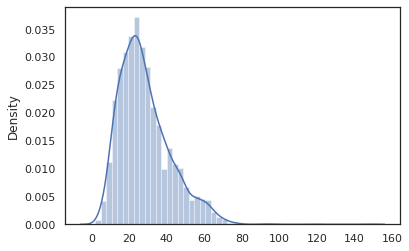

In [74]:
# Check the distribution to decide the maximum length
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
sns.distplot([len(tokenizer.tokenize(text)) for text in train_df['sentence']])

In [75]:
# # Define input class and bert encoder
# # Comment out this as the function is now provided by Huggingface

# class InputFeature(object):
#     """ A single training/test data class """
#     def __init__(self, id, input_ids, masks, segments, label=None):
#         self.id = id
#         self.features = {
#             'input_ids': input_ids,
#             'input_mask': masks,
#             'segment_ids': segments
#         }
#         self.label = label

# def bert_encoder(text, max_len=80):
#     """ Return embedded text vector as a list in max_len with a mask list"""
#     text_token = tokenizer.tokenize(text)
#     text_token = text_token[:max_len-2]
#     text_token = ["[CLS]"] + text_token + ["[SEP]"]
#     text_ids = tokenizer.convert_tokens_to_ids(text_token)
#     text_ids += [0] * (max_len - len(text_token))
#     pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
#     segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
#     return text_ids, pad_masks, segment_ids

In [76]:
# Define a DataSet Class which simply return (x, y) pair instead
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.datalist=[(x[i], y[i]) for i in range(len(y))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self,idx):
        return(self.datalist[idx])

### Define Bert Model

In [77]:
class BertTextClassifier(nn.Module):
    def __init__(self, hidden_size, dense_size, output_size, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.output_size = output_size
        self.dropout = dropout
        
        self.bert = BertModel.from_pretrained('bert-base-uncased',  
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids):
        """
        Perform a forward pass of the model on nn_input
        """
        
        all_hidden_states, all_attentions = self.bert(input_ids)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])        
        # Dense layer
        dense_out = self.fc1(self.dropout(feature))
        # Concatinate the dense output and meta inputs
        #  concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(dense_out)
        # out = self.fc(self.dropout(feature))

        return out

In [78]:
# Test the model and tokenizer

# Comment out here as not using own implementation
# bert_model = BertTextClassifier(768, 128, 3, dropout=0.1)
# text_ids, pad_masks, segment_ids = bert_encoder("Hello, my dog is cute")
# tokenizer.encode() returns only input_ids, whereas tokenizer() returns dict

#print('text_ids: \n', text_ids)
#print('text_ids (torch.tensor): \n', torch.tensor(text_ids))
#text_ids = torch.tensor(text_ids).unsqueeze(0)
#print('text_ids (unsqueezed): \n', text_ids)
#pad_masks = torch.tensor(pad_masks).unsqueeze(0)
#print('pad_masks: ',pad_masks)
#segment_ids = torch.tensor(segment_ids).unsqueeze(0)
#print('segment_ids: ',segment_ids)

#outputs = bert_model(text_ids)
#outputs = bert_model(text_ids, pad_masks, segment_ids)

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
inputs = tokenizer("Hello, my dog is cute", 
                   return_tensors="pt", 
                   pad_to_max_length=True, 
                   max_length = 64,
                   add_special_tokens=True,
                   padding_side='right')
print('inputs: \n', inputs)
print('\ndecoded: \n',tokenizer.decode(inputs['input_ids'].squeeze(0)))

labels = torch.tensor([1]).unsqueeze(0)
print('\nlabels: ', labels)

outputs = bert_model(**inputs, labels=labels)
print('\noutputs: length=', len(outputs))
print(outputs)

loss = outputs[0]
logits = outputs[1]

print('loss: ', loss.detach())
print('logits: ', logits.detach())

print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs[0].detach())


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

inputs: 
 {'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Input Data

In [79]:
# Split the data
msk = np.random.rand(len(train_df)) < 0.8
train = train_df[msk]
test = train_df[~msk]

In [80]:
# Prepare training data
# Comment out here as not using own implementation

# train_set, test_set = [], []
# max_seq_length = 48

# for index, row in tqdm(train.iterrows(), total=train.shape[0]):
#     input_ids, masks, segments = bert_encoder(row['sentence'], max_seq_length)
#     train_set.append(InputFeature(row.index, input_ids, masks, segments, int(row['label'])))    

# train_labels = train['label'].astype(int).values

# for index, row in tqdm(test.iterrows(), total=test.shape[0]):
#     input_ids, masks, segments = bert_encoder(row['sentence'], max_seq_length)
#     test_set.append(InputFeature(row.index, input_ids, masks, segments, int(row['label'])))    

# test_labels = test['label'].astype(int).values

# # numpy array to split train and valid within Fold later
# train_valid_input_ids = np.array([data.features['input_ids'] for data in train_set])
# train_valid_input_masks = np.array([data.features['input_mask'] for data in train_set])
# train_valid_segment_ids =np.array([data.features['segment_ids'] for data in train_set])
# train_valid_labels = np.array([data.label for data in train_set])

# oof_train = np.zeros((len(train_df), 3), dtype=np.float32)

# # test data
# test_input_ids = [data.features['input_ids'] for data in test_set]
# test_input_masks = [data.features['input_mask'] for data in test_set]
# test_segment_ids =[data.features['segment_ids'] for data in test_set]
# test_labels = [data.label for data in test_set]


### Train

In [81]:
def train_transformer(model, x_train, y_train, x_valid, y_valid, learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length):
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    # # Train Data in Tensor
    # train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    # train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    # train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    # train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    
    # # Validation Data in Tensor
    # valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    # valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    # valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    # valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)

    # # Load data into TensorDataset
    # train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_label)
    # valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_label)
    
    # Load data into SimpleDataset
    train_ds = SimpleDataset(x_train, y_train)
    valid_ds = SimpleDataset(x_valid, y_valid)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    
    num_total_opt_steps = int(len(train_loader) * num_epochs)
    print('Total Training Steps: {} ({} batches x {} epochs)'.format(num_total_opt_steps, len(train_loader), num_epochs))
    
    # Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    # To reproduce BertAdam specific behavior set correct_bias=False
    optimizer = AdamW_HF(model.parameters(), lr=learning_rate, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler

    ## Set Loss Function
    ## If we use BertForSequenceClassification, Loss function is already included and no need to define.
    # Loss Function - use Cross Entropy as binary classification
    # loss_fn = torch.nn.CrossEntropyLoss()

    ## Set Optimizer
    ## Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    ## If we use torch.optim.Adam, set with parameter groups like this:
    # param_optimizer = list(model.named_parameters())
    # no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    # optimizer_grouped_parameters = [
    #     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    #     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
    # optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)

    # Set Train Mode
    model.train()
    
    # Tokenizer Parameter
    param_tk = {
        'return_tensors': "pt",
        'padding': 'max_length',
        'max_length': max_seq_length,
        'add_special_tokens': True,
        'truncation': True
    }

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((len(y_valid), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    total_steps = 0
    train_loss_set = []
    
    for epoch in tqdm(range(num_epochs), desc="Epoch"):
        # print('================     epoch {}     ==============='.format(epoch+1))
        train_loss = 0.

        for i, batch in enumerate(train_loader):
            # Input features and labels from batch and move to device
            x_train_bt, y_train_bt = batch
            x_train_bt = tokenizer(x_train_bt, **param_tk).to(device)
            y_train_bt = torch.tensor(y_train_bt, dtype=torch.long).to(device)
            
            # Reset gradient
            optimizer.zero_grad()

            # Feedforward prediction
            # y_pred = bert_model(x_ids, x_mask, x_sids)
            loss, logits = model(**x_train_bt, labels=y_train_bt)

            # Calculate Loss - no longer required.
            # loss = loss_fn(y_pred[0], y_truth)

            # Backward Propagation
            loss.backward()

            # Training Loss
            train_loss += loss.item() / len(train_loader)
            train_loss_set.append(loss.item())

            # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()
            
            logger.debug('train batch: %d, train_loss: %8f' % (i, loss.item() / len(train_loader)))
            total_steps += 1

        train_losses.append(train_loss)

        # Move to Evaluation Mode
        model.eval()
        
        # Initialize for Validation
        val_loss = 0.
        #valid_preds_fold = np.zeros((y_valid.size(0), 3))
        y_valid_pred = np.zeros((len(y_valid), 3))
        
        with torch.no_grad():
            for i, batch in enumerate(valid_loader):
                # Input features and labels from batch and move to device
                x_valid_bt, y_valid_bt = batch
                x_valid_bt = tokenizer(x_valid_bt, **param_tk).to(device)
                y_valid_bt = torch.tensor(y_valid_bt, dtype=torch.long).to(device)
            
                loss, logits = model(**x_valid_bt, labels=y_valid_bt)
                val_loss += loss.item() / len(valid_loader)
                y_valid_pred[i * batch_size:(i + 1) * batch_size] = F.softmax(logits, dim=1).cpu().numpy()
                logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))
        valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(y_valid, np.argmax(y_valid_pred, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = y_valid_pred
            #torch.save(model.state_dict(), output_dir + out_model_name)
        else:
            early_stop += 1
            
        print('epoch: %d, train loss: %.4f, valid loss: %.4f, acc: %.4f, f1: %.4f, best_f1: %.4f, last lr: %.6f' %
              (epoch+1, train_loss, val_loss, acc, f1, best_f1, scheduler.get_last_lr()[0]))
        
        logger.debug('valid_best: {}'.format(np.argmax(valid_best, axis=1)))

        if device == 'cuda:0':
            torch.cuda.empty_cache()

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Back to Train Mode
        model.train()

    # Once all epochs are done, output summaries
    print('================ Training Completed: Starting Post Process ===============')
    
    # Draw training/validation losses
    plt.figure(figsize=(15,6))
    plt.plot(train_losses, 'b-o', label='Training Loss')
    plt.plot(valid_losses, 'r-o', label='Validation Loss')
    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

    ## Load the best model
    #model.load_state_dict(torch.load(output_dir + out_model_name))
    ## Set the model to Evaluation Mode
    #model.eval()
    
    # Check the metrics for the validation set
    acc, f1 = metric(y_valid, np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    # Convert to class names from 0, 1, 2
    class_names = ['Negative', 'Neutral', 'Positive']
    y_valid_class = [class_names[int(idx)] for idx in y_valid]
    pred_valid_class = [class_names[int(idx)] for idx in np.argmax(valid_best, axis=1)]

    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, pred_valid_class, normalize=normalize, title=title)
    plt.show()

    # plot training performance
    plt.figure(figsize=(15,8))
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(train_loss_set)
    plt.show()
    
    return acc, f1, valid_best

In [82]:
# Hyperparameters
learning_rate = 2e-5
num_epochs = 5
batch_size = 32
patience = 3
warm_up_proportion = 0.1
max_grad_norm = 1.0
max_seq_length = 48

# bert_hidden_size = 768
# bert_dense_size = 128

================     fold 1    ===============


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Total Training Steps: 345 (69 batches x 5 epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 1, train loss: 0.5509, valid loss: 0.3999, acc: 0.8412, f1: 0.8274, best_f1: 0.8274, last lr: 0.000018
epoch: 2, train loss: 0.1845, valid loss: 0.2504, acc: 0.9343, f1: 0.9120, best_f1: 0.9120, last lr: 0.000013
epoch: 3, train loss: 0.0754, valid loss: 0.2834, acc: 0.9325, f1: 0.9035, best_f1: 0.9120, last lr: 0.000009
epoch: 4, train loss: 0.0291, valid loss: 0.3075, acc: 0.9252, f1: 0.8970, best_f1: 0.9120, last lr: 0.000004
epoch: 5, train loss: 0.0182, valid loss: 0.2883, acc: 0.9325, f1: 0.9043, best_f1: 0.9120, last lr: 0.000000
================ Training Completed: Starting Post Process ===============


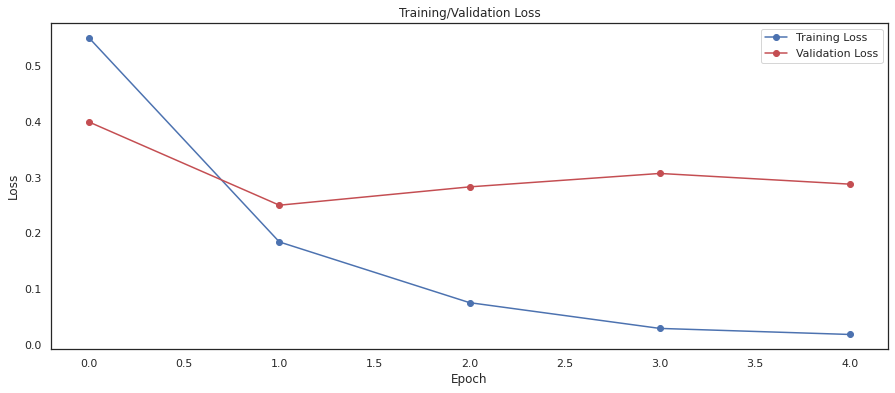

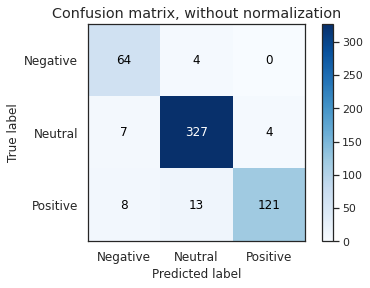

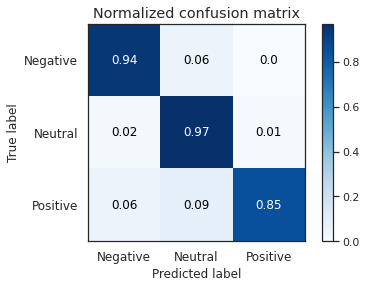

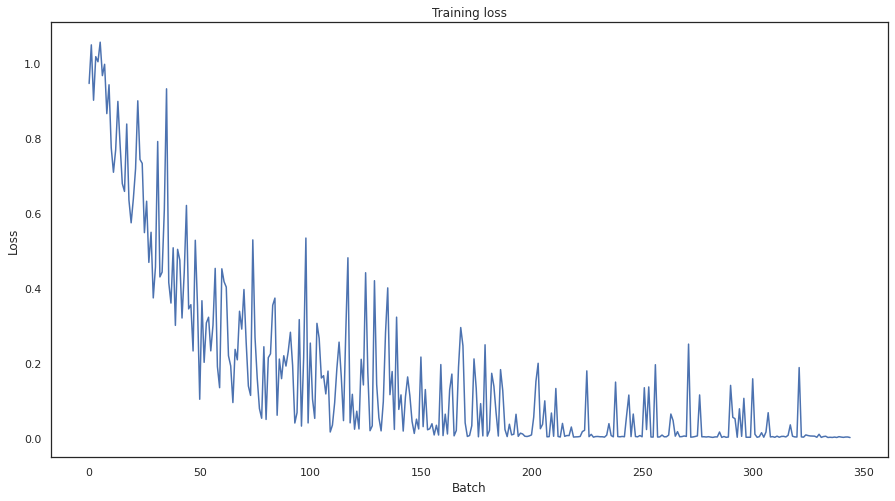

================     fold 2    ===============


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Total Training Steps: 345 (69 batches x 5 epochs)


epoch: 1, train loss: 0.5985, valid loss: 0.2727, acc: 0.9033, f1: 0.8783, best_f1: 0.8783, last lr: 0.000018
epoch: 2, train loss: 0.1784, valid loss: 0.2008, acc: 0.9252, f1: 0.8998, best_f1: 0.8998, last lr: 0.000013
epoch: 3, train loss: 0.0794, valid loss: 0.2234, acc: 0.9325, f1: 0.9103, best_f1: 0.9103, last lr: 0.000009
epoch: 4, train loss: 0.0349, valid loss: 0.2527, acc: 0.9288, f1: 0.9065, best_f1: 0.9103, last lr: 0.000004
epoch: 5, train loss: 0.0199, valid loss: 0.2684, acc: 0.9307, f1: 0.9082, best_f1: 0.9103, last lr: 0.000000

================ Training Completed: Starting Post Process ===============


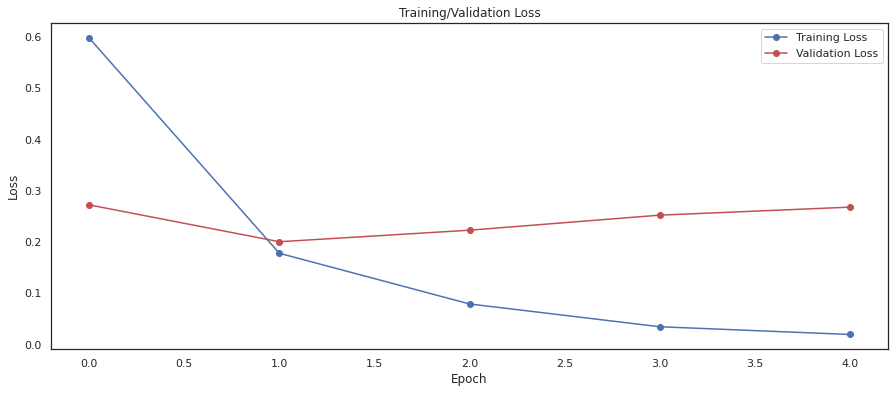

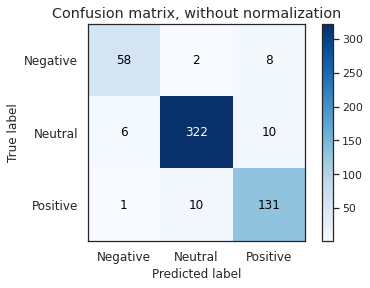

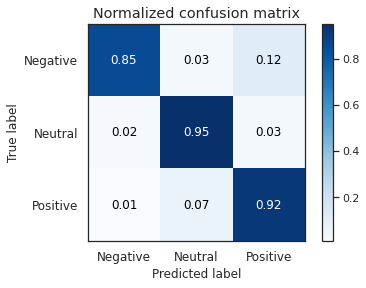

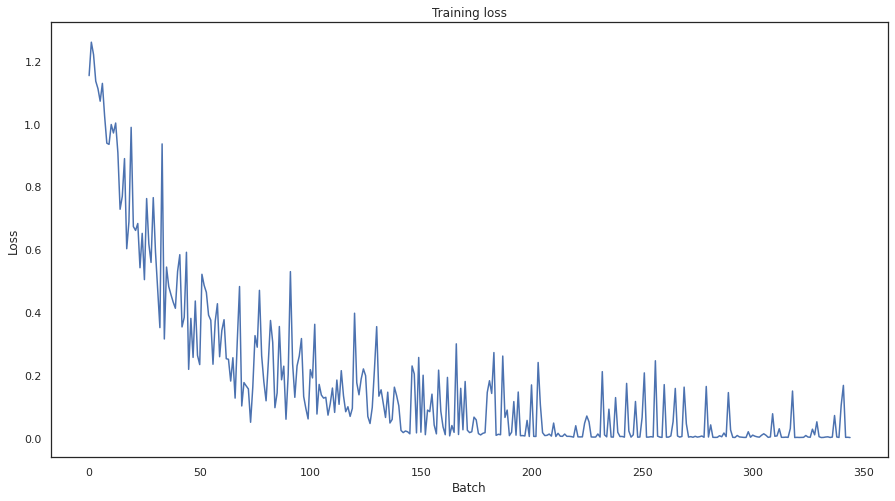

================     fold 3    ===============


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Total Training Steps: 345 (69 batches x 5 epochs)


epoch: 1, train loss: 0.5774, valid loss: 0.3522, acc: 0.8741, f1: 0.8608, best_f1: 0.8608, last lr: 0.000018
epoch: 2, train loss: 0.1721, valid loss: 0.2958, acc: 0.8942, f1: 0.8578, best_f1: 0.8608, last lr: 0.000013
epoch: 3, train loss: 0.0655, valid loss: 0.3183, acc: 0.9124, f1: 0.8830, best_f1: 0.8830, last lr: 0.000009
epoch: 4, train loss: 0.0289, valid loss: 0.3409, acc: 0.9197, f1: 0.8924, best_f1: 0.8924, last lr: 0.000004
epoch: 5, train loss: 0.0186, valid loss: 0.3577, acc: 0.9179, f1: 0.8893, best_f1: 0.8924, last lr: 0.000000

================ Training Completed: Starting Post Process ===============


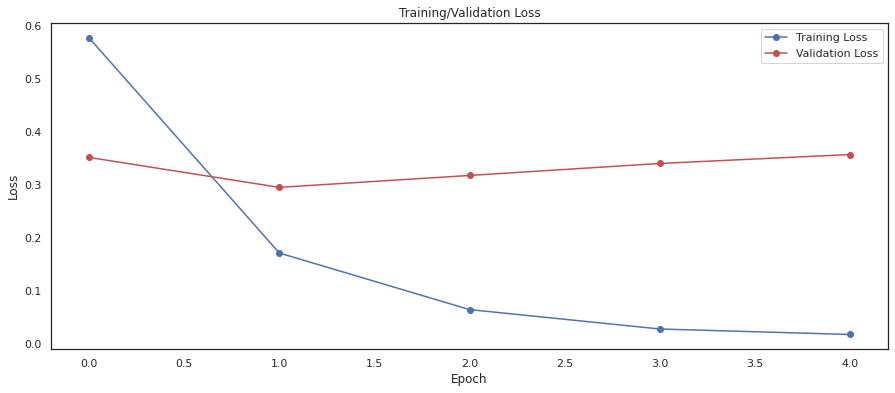

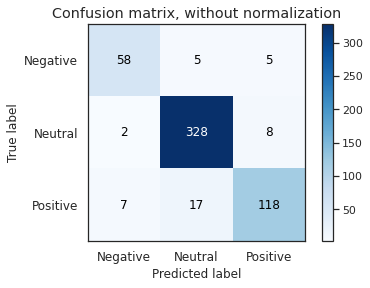

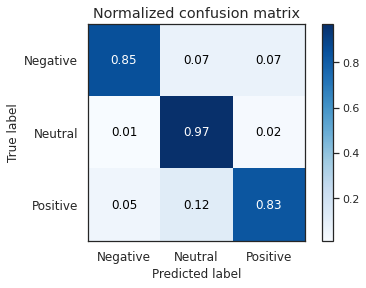

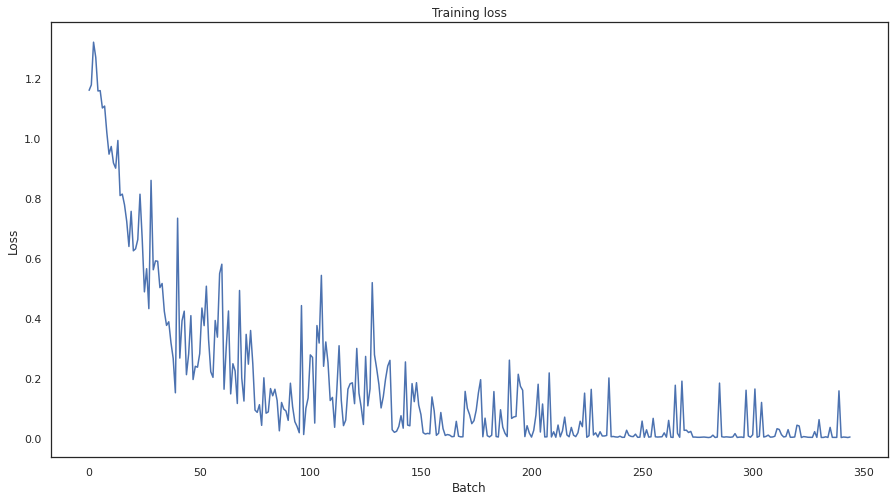

================     fold 4    ===============


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Total Training Steps: 345 (69 batches x 5 epochs)


epoch: 1, train loss: 0.6161, valid loss: 0.2501, acc: 0.9159, f1: 0.8931, best_f1: 0.8931, last lr: 0.000018
epoch: 2, train loss: 0.2135, valid loss: 0.2369, acc: 0.9214, f1: 0.8981, best_f1: 0.8981, last lr: 0.000013
epoch: 3, train loss: 0.0891, valid loss: 0.2611, acc: 0.9305, f1: 0.9123, best_f1: 0.9123, last lr: 0.000009
epoch: 4, train loss: 0.0458, valid loss: 0.3006, acc: 0.9250, f1: 0.9085, best_f1: 0.9123, last lr: 0.000004
epoch: 5, train loss: 0.0225, valid loss: 0.2987, acc: 0.9269, f1: 0.9143, best_f1: 0.9143, last lr: 0.000000

================ Training Completed: Starting Post Process ===============


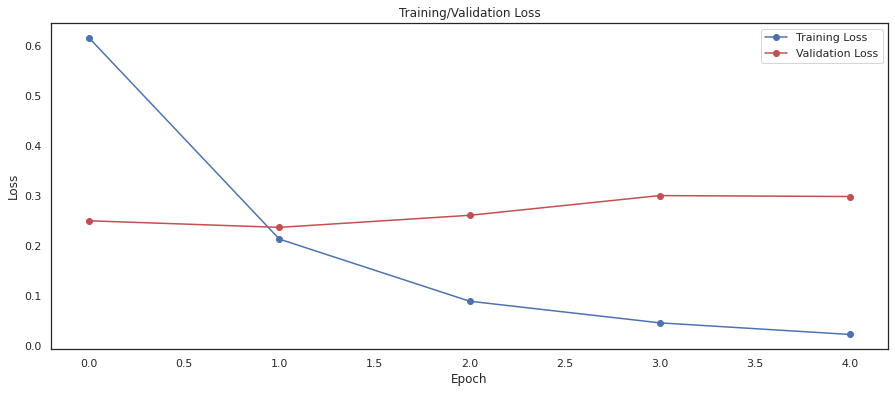

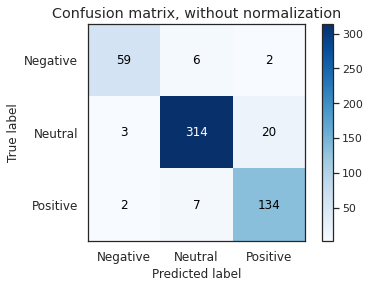

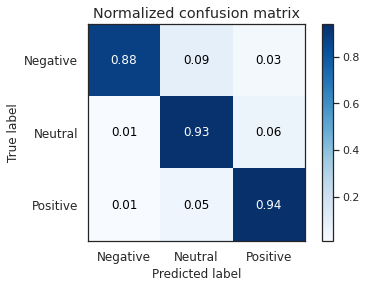

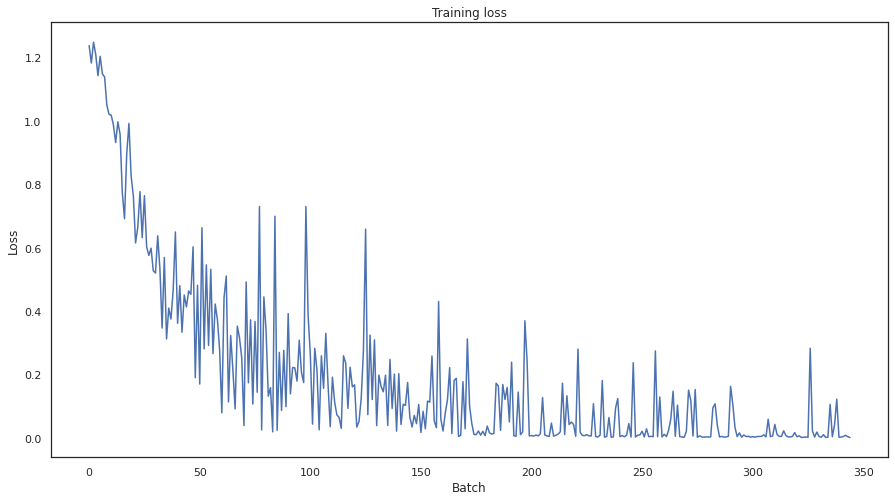

================     fold 5    ===============


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Total Training Steps: 345 (69 batches x 5 epochs)


epoch: 1, train loss: 0.5994, valid loss: 0.2459, acc: 0.9122, f1: 0.8840, best_f1: 0.8840, last lr: 0.000018
epoch: 2, train loss: 0.1841, valid loss: 0.2219, acc: 0.9269, f1: 0.9060, best_f1: 0.9060, last lr: 0.000013
epoch: 3, train loss: 0.0747, valid loss: 0.2265, acc: 0.9378, f1: 0.9272, best_f1: 0.9272, last lr: 0.000009
epoch: 4, train loss: 0.0311, valid loss: 0.2807, acc: 0.9342, f1: 0.9228, best_f1: 0.9272, last lr: 0.000004
epoch: 5, train loss: 0.0136, valid loss: 0.2792, acc: 0.9342, f1: 0.9230, best_f1: 0.9272, last lr: 0.000000

================ Training Completed: Starting Post Process ===============


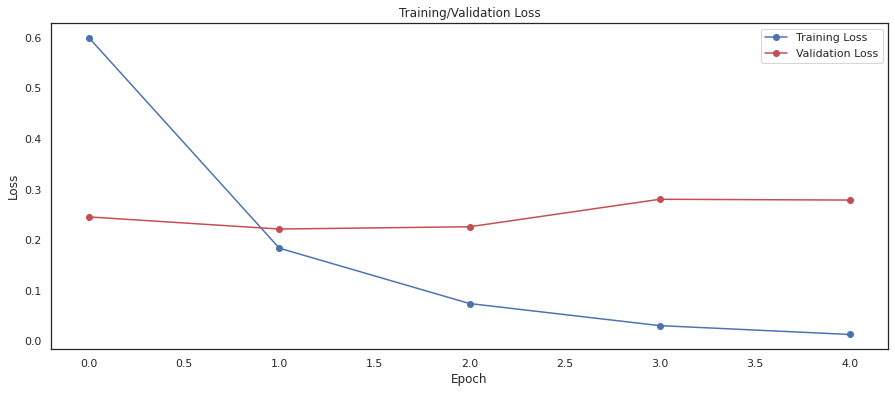

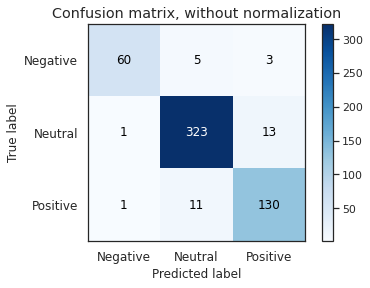

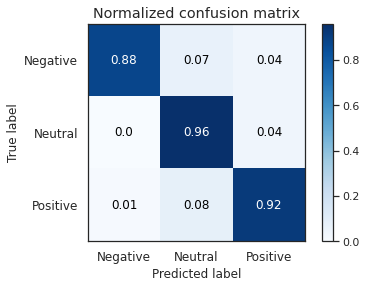

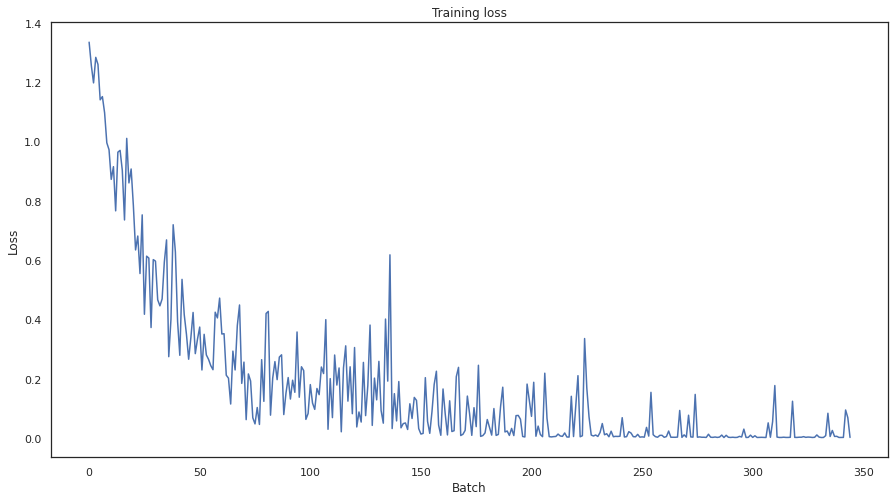

#################### FINAL RESULT ####################
Average Accuracy: 0.93024260, Average F1: 0.91123181


In [83]:
# Run the training with Stratified KFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_seed)

# Input Data
x_train = np.array(train['sentence'])
y_train = np.array(train['label'].astype(int).values)
oof_train = np.zeros((len(train), 3), dtype=np.float32)

# Set Log Level
logger = set_logger(logging.INFO)

acc_list, f1_list = [], []

for n_fold, (train_indices, valid_indices) in enumerate(skf.split(y_train, y_train)):
    #logger.info('================     fold {}    ==============='.format(n_fold+1))
    print('================     fold {}    ==============='.format(n_fold+1))
    # Input train data for this fold
    x_train_fold = x_train[train_indices]
    y_train_fold = y_train[train_indices]
    # Input validation data for this fold
    x_valid_fold = x_train[valid_indices]
    y_valid_fold = y_train[valid_indices]

    # Make sure to load the pre-trained model every time
    bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    
    acc, f1, valid_best = \
        train_transformer(bert_model, x_train_fold, y_train_fold, x_valid_fold, y_valid_fold, \
                          learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
    oof_train[valid_indices] = valid_best

    acc_list.append(acc)
    f1_list.append(f1)
    
    
    # Number of folds to iterrate
    if n_fold == 10:
        break


print("#################### FINAL RESULT ####################")

avg_acc = np.mean(acc_list)
avg_f1 = np.mean(f1_list)

print("Average Accuracy: %.8f, Average F1: %.8f" % (avg_acc, avg_f1))


## Test and Result
Make sure you do not run the test until the model is fixed by cross validation.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Total Training Steps: 430 (86 batches x 5 epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 1, train loss: 0.5552, valid loss: 0.2650, acc: 0.9127, f1: 0.8569, best_f1: 0.8569, last lr: 0.000018
epoch: 2, train loss: 0.1740, valid loss: 0.1640, acc: 0.9408, f1: 0.9138, best_f1: 0.9138, last lr: 0.000013
epoch: 3, train loss: 0.0628, valid loss: 0.2268, acc: 0.9437, f1: 0.9292, best_f1: 0.9292, last lr: 0.000009
epoch: 4, train loss: 0.0252, valid loss: 0.2169, acc: 0.9521, f1: 0.9346, best_f1: 0.9346, last lr: 0.000004
epoch: 5, train loss: 0.0142, valid loss: 0.2047, acc: 0.9507, f1: 0.9336, best_f1: 0.9346, last lr: 0.000000

================ Training Completed: Starting Post Process ===============


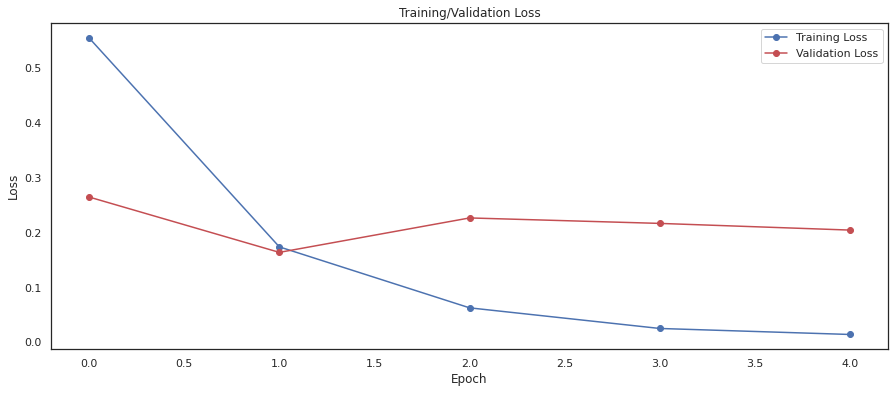

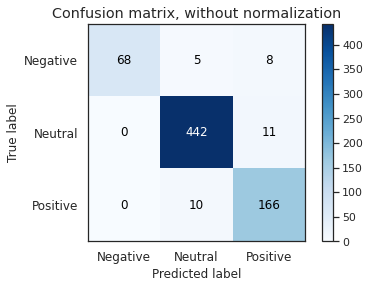

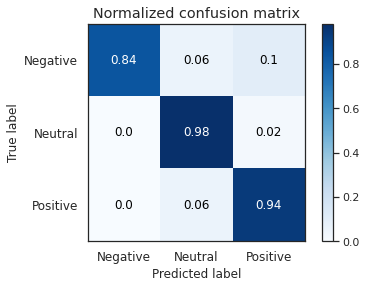

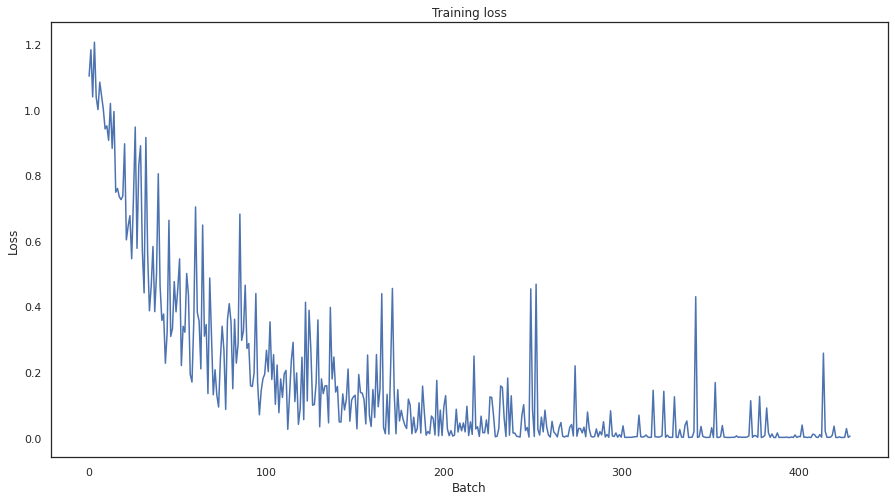

Accuracy: 0.95211268, f1: 0.93461595



In [84]:
# Re-train the model with all Train set and validate on Test set

# Input Data
x_test = np.array(test['sentence'])
y_test = np.array(test['label'].astype(int).values)

# Make sure to load the pre-trained model every time
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

acc, f1, valid_best = \
        train_transformer(bert_model, x_train, y_train, x_test, y_test, \
                          learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
    
print(('Accuracy: %.8f, f1: %.8f\n' % (acc, f1)))

In [85]:
result_df.loc['D1: BERT'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,F1
A: Lexicon,0.6536,0.4683
B: Tfidf,0.8203,0.7163
C1: LSTM,0.7672,0.7184
C2: LSTM+GloVe,0.7891,0.7169
D1: BERT,0.9521,0.9346
D2: ALBERT,NaN,NaN


# D2: ALBERT

### Model and Train

In [86]:
# Set Tokenizer and Model
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AlbertModel
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

In [87]:
# Hyperparameters
learning_rate = 1e-5
num_epochs = 5
batch_size = 32
patience = 3
warm_up_proportion = 0.1
max_grad_norm = 1.0
max_seq_length = 48

# bert_hidden_size = 768
# bert_dense_size = 128

================     fold 1    ===============


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

Total Training Steps: 345 (69 batches x 5 epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 1, train loss: 0.6627, valid loss: 0.4933, acc: 0.8321, f1: 0.7599, best_f1: 0.7599, last lr: 0.000009
epoch: 2, train loss: 0.3391, valid loss: 0.2977, acc: 0.8996, f1: 0.8645, best_f1: 0.8645, last lr: 0.000007
epoch: 3, train loss: 0.1724, valid loss: 0.2951, acc: 0.9106, f1: 0.8877, best_f1: 0.8877, last lr: 0.000004
epoch: 4, train loss: 0.1087, valid loss: 0.3574, acc: 0.9106, f1: 0.8851, best_f1: 0.8877, last lr: 0.000002
epoch: 5, train loss: 0.0682, valid loss: 0.3341, acc: 0.9179, f1: 0.8955, best_f1: 0.8955, last lr: 0.000000

================ Training Completed: Starting Post Process ===============


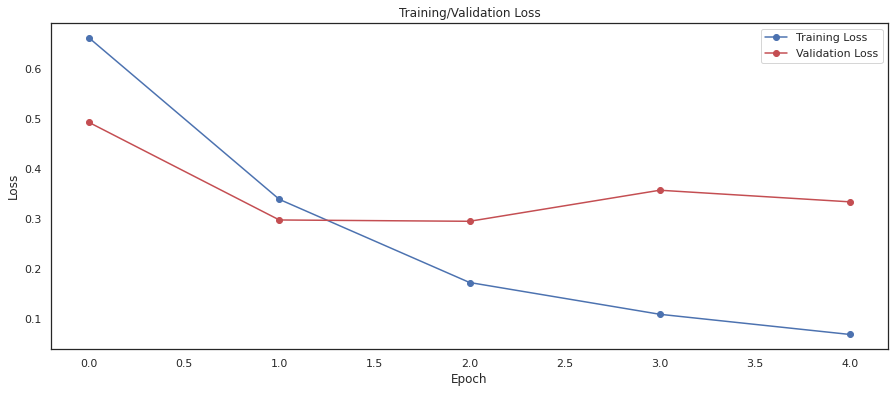

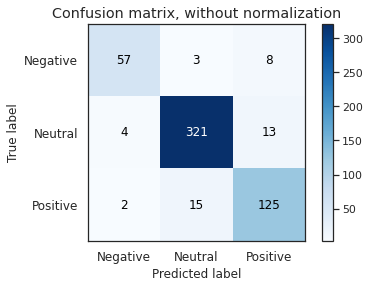

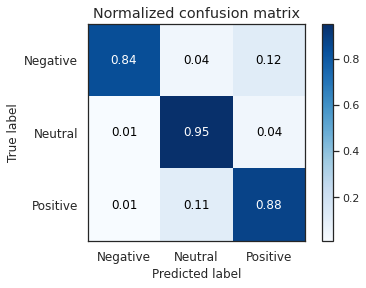

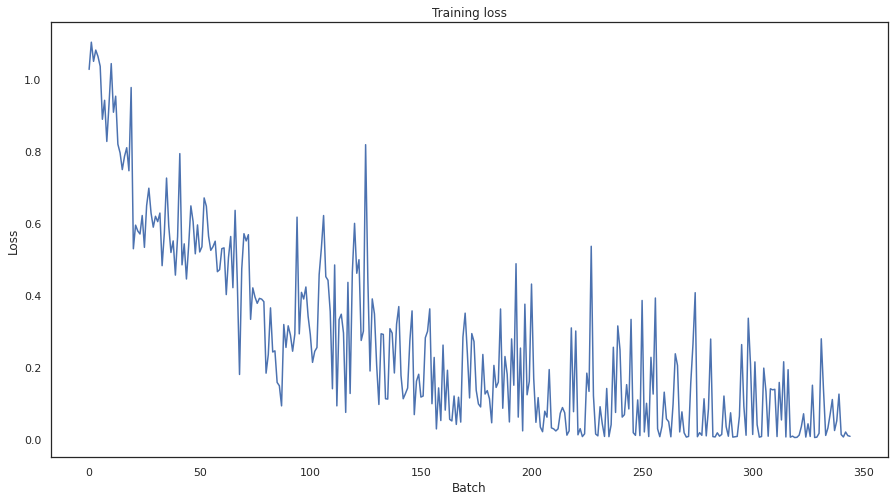

================     fold 2    ===============


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

Total Training Steps: 345 (69 batches x 5 epochs)


epoch: 1, train loss: 0.6660, valid loss: 0.4334, acc: 0.8595, f1: 0.8114, best_f1: 0.8114, last lr: 0.000009
epoch: 2, train loss: 0.2839, valid loss: 0.2705, acc: 0.8996, f1: 0.8902, best_f1: 0.8902, last lr: 0.000007
epoch: 3, train loss: 0.1774, valid loss: 0.2394, acc: 0.9270, f1: 0.9058, best_f1: 0.9058, last lr: 0.000004
epoch: 4, train loss: 0.1073, valid loss: 0.2892, acc: 0.9288, f1: 0.9100, best_f1: 0.9100, last lr: 0.000002
epoch: 5, train loss: 0.0681, valid loss: 0.2985, acc: 0.9288, f1: 0.9119, best_f1: 0.9119, last lr: 0.000000

================ Training Completed: Starting Post Process ===============


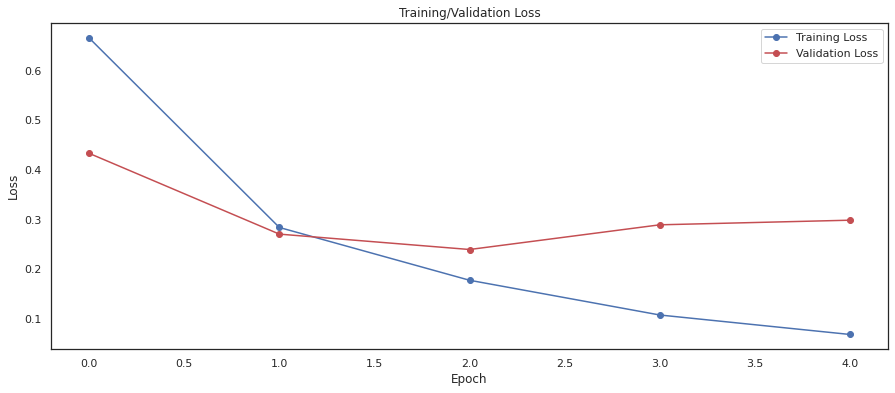

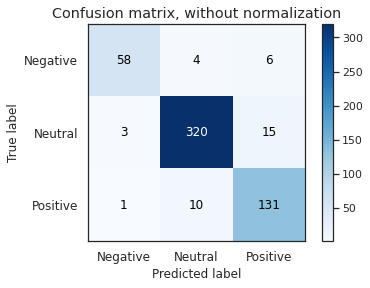

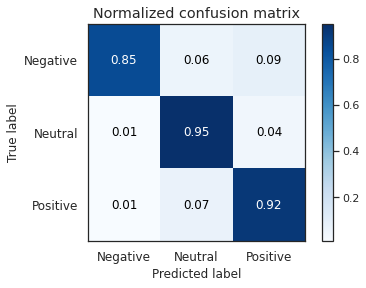

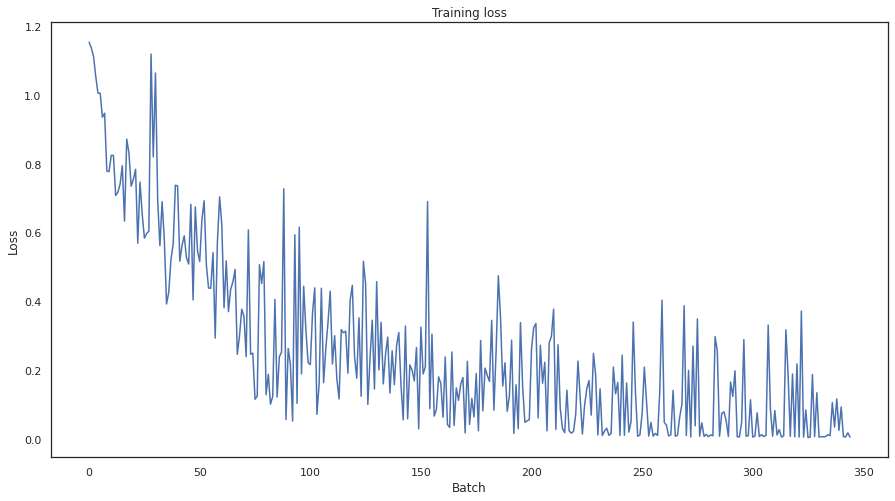

================     fold 3    ===============


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

Total Training Steps: 345 (69 batches x 5 epochs)


epoch: 1, train loss: 0.7115, valid loss: 0.5891, acc: 0.7774, f1: 0.5858, best_f1: 0.5858, last lr: 0.000009
epoch: 2, train loss: 0.4175, valid loss: 0.3502, acc: 0.8741, f1: 0.8378, best_f1: 0.8378, last lr: 0.000007
epoch: 3, train loss: 0.1819, valid loss: 0.3326, acc: 0.8942, f1: 0.8641, best_f1: 0.8641, last lr: 0.000004
epoch: 4, train loss: 0.1093, valid loss: 0.3567, acc: 0.9106, f1: 0.8876, best_f1: 0.8876, last lr: 0.000002
epoch: 5, train loss: 0.0682, valid loss: 0.3764, acc: 0.9015, f1: 0.8678, best_f1: 0.8876, last lr: 0.000000

================ Training Completed: Starting Post Process ===============


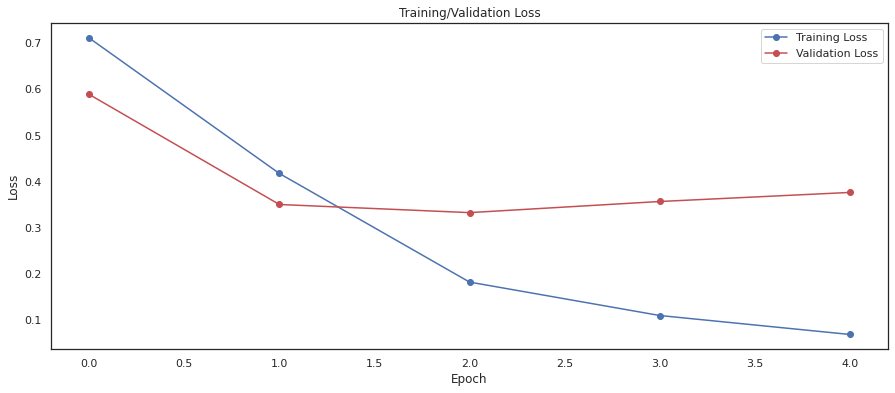

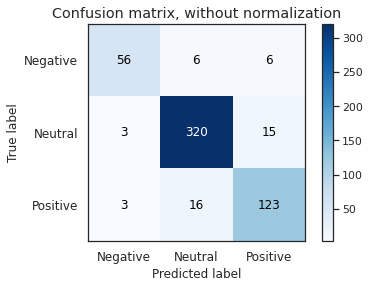

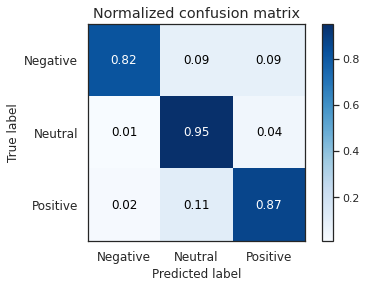

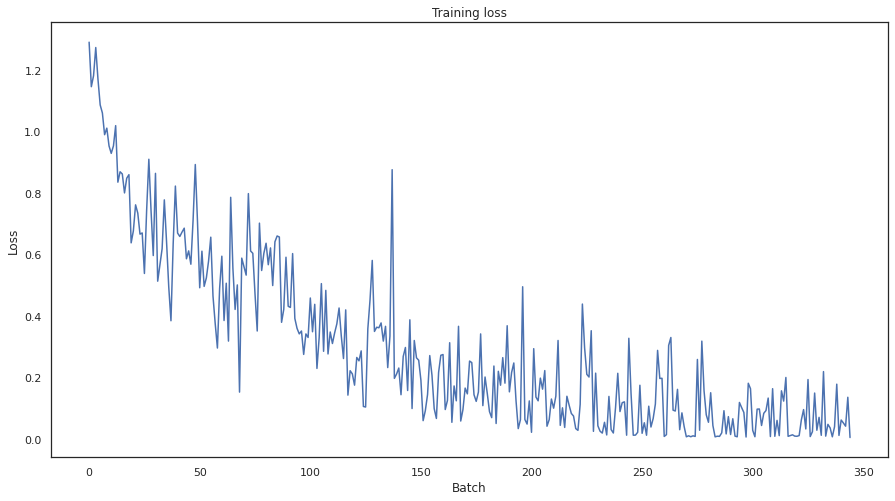

================     fold 4    ===============


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

Total Training Steps: 345 (69 batches x 5 epochs)


epoch: 1, train loss: 0.5839, valid loss: 0.3862, acc: 0.8830, f1: 0.8454, best_f1: 0.8454, last lr: 0.000009
epoch: 2, train loss: 0.2584, valid loss: 0.2661, acc: 0.9196, f1: 0.8924, best_f1: 0.8924, last lr: 0.000007
epoch: 3, train loss: 0.1315, valid loss: 0.2855, acc: 0.9177, f1: 0.8955, best_f1: 0.8955, last lr: 0.000004
epoch: 4, train loss: 0.0923, valid loss: 0.2767, acc: 0.9287, f1: 0.9074, best_f1: 0.9074, last lr: 0.000002
epoch: 5, train loss: 0.0575, valid loss: 0.2879, acc: 0.9269, f1: 0.9073, best_f1: 0.9074, last lr: 0.000000

================ Training Completed: Starting Post Process ===============


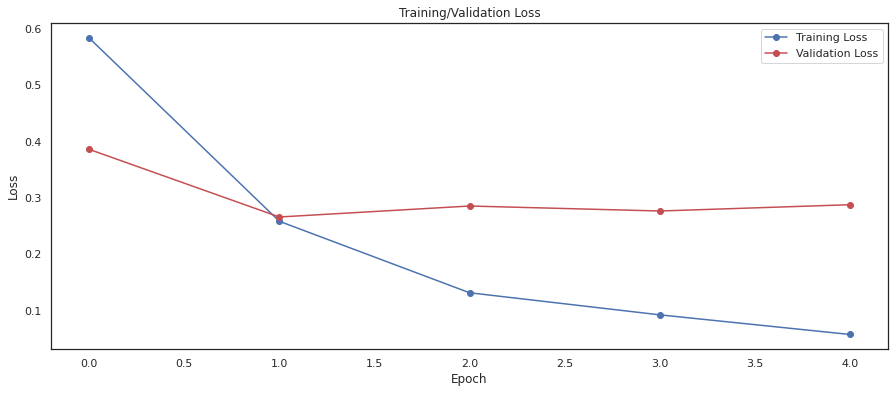

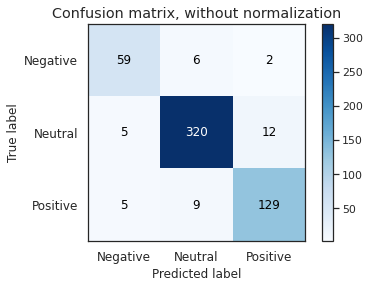

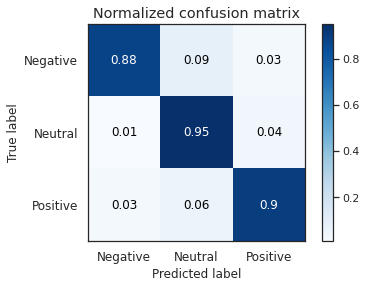

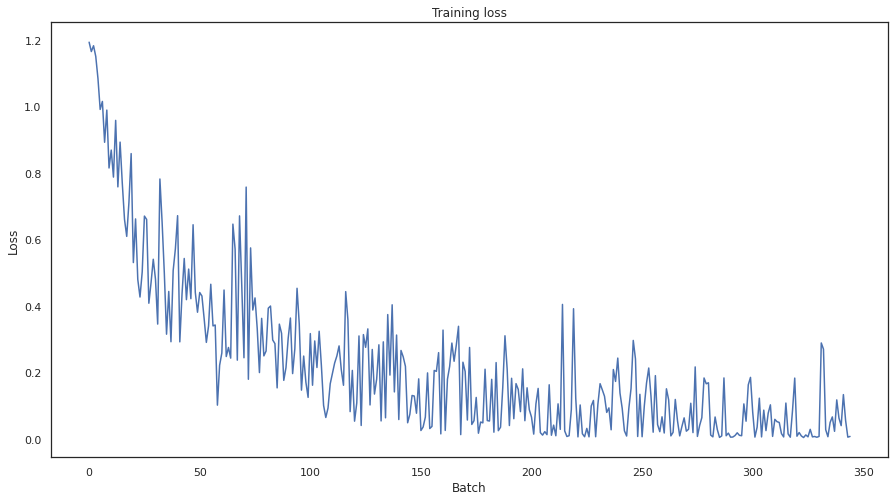

================     fold 5    ===============


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

Total Training Steps: 345 (69 batches x 5 epochs)


epoch: 1, train loss: 0.6080, valid loss: 0.4111, acc: 0.8793, f1: 0.8568, best_f1: 0.8568, last lr: 0.000009
epoch: 2, train loss: 0.2874, valid loss: 0.2190, acc: 0.9232, f1: 0.9071, best_f1: 0.9071, last lr: 0.000007
epoch: 3, train loss: 0.1716, valid loss: 0.2262, acc: 0.9360, f1: 0.9251, best_f1: 0.9251, last lr: 0.000004
epoch: 4, train loss: 0.0966, valid loss: 0.2533, acc: 0.9324, f1: 0.9212, best_f1: 0.9251, last lr: 0.000002
epoch: 5, train loss: 0.0546, valid loss: 0.2662, acc: 0.9324, f1: 0.9220, best_f1: 0.9251, last lr: 0.000000

================ Training Completed: Starting Post Process ===============


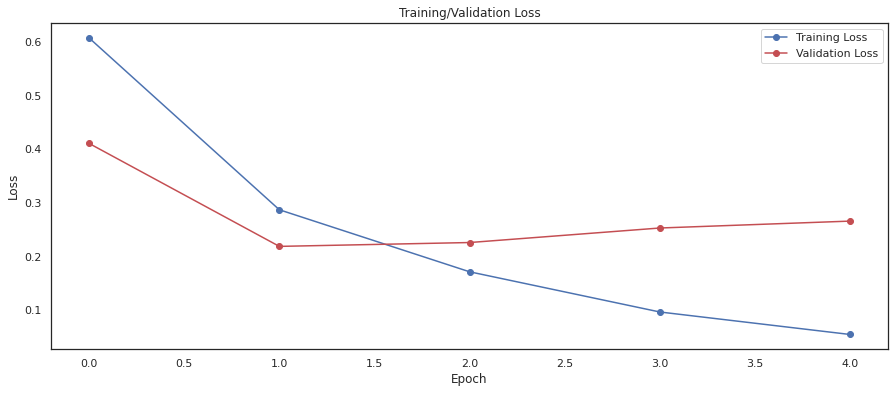

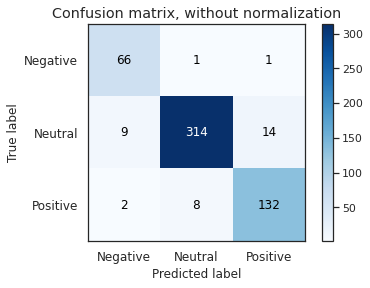

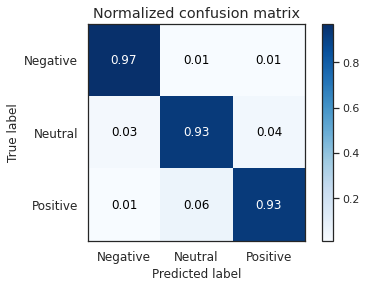

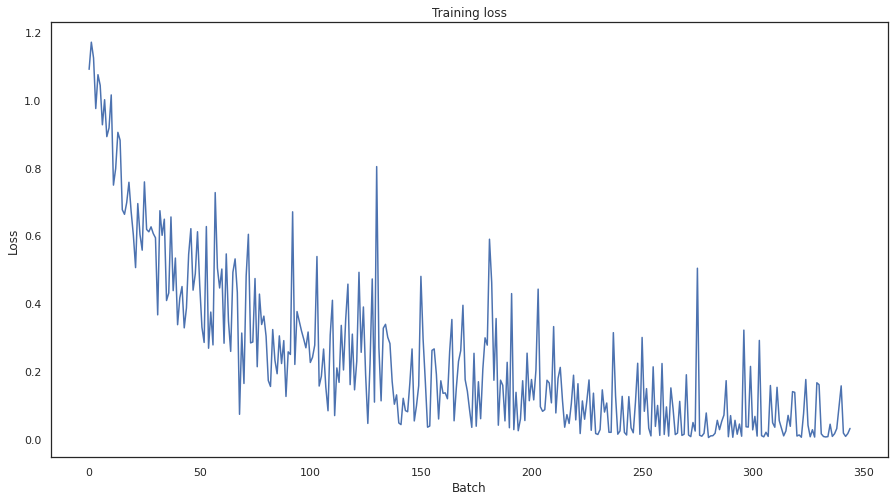

#################### FINAL RESULT ####################
Average Accuracy: 0.92440318, Average F1: 0.90551777


In [88]:
# Run the training with Stratified KFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_seed)

# Input Data
x_train = np.array(train['sentence'])
y_train = np.array(train['label'].astype(int).values)
oof_train = np.zeros((len(train), 3), dtype=np.float32)

# Set Log Level
logger = set_logger(logging.INFO)

acc_list, f1_list = [], []

for n_fold, (train_indices, valid_indices) in enumerate(skf.split(y_train, y_train)):
    #logger.info('================     fold {}    ==============='.format(n_fold+1))
    print('================     fold {}    ==============='.format(n_fold+1))
    # Input train data for this fold
    x_train_fold = x_train[train_indices]
    y_train_fold = y_train[train_indices]
    # Input validation data for this fold
    x_valid_fold = x_train[valid_indices]
    y_valid_fold = y_train[valid_indices]

    # Make sure to load the pre-trained model every time
    albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)
    
    acc, f1, valid_best = \
        train_transformer(albert_model, x_train_fold, y_train_fold, x_valid_fold, y_valid_fold, \
                          learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
    oof_train[valid_indices] = valid_best

    acc_list.append(acc)
    f1_list.append(f1)
    
    
    # Number of folds to iterrate
    if n_fold == 10:
        break


print("#################### FINAL RESULT ####################")

avg_acc = np.mean(acc_list)
avg_f1 = np.mean(f1_list)

print("Average Accuracy: %.8f, Average F1: %.8f" % (avg_acc, avg_f1))


### Test and Result
Make sure you do not run the test until the model is fixed by cross validation.

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

Total Training Steps: 430 (86 batches x 5 epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 1, train loss: 0.6313, valid loss: 0.3817, acc: 0.8746, f1: 0.8143, best_f1: 0.8143, last lr: 0.000009
epoch: 2, train loss: 0.2906, valid loss: 0.2227, acc: 0.9225, f1: 0.8908, best_f1: 0.8908, last lr: 0.000007
epoch: 3, train loss: 0.1538, valid loss: 0.1991, acc: 0.9366, f1: 0.9109, best_f1: 0.9109, last lr: 0.000004
epoch: 4, train loss: 0.0895, valid loss: 0.2244, acc: 0.9324, f1: 0.9044, best_f1: 0.9109, last lr: 0.000002
epoch: 5, train loss: 0.0502, valid loss: 0.2399, acc: 0.9338, f1: 0.9083, best_f1: 0.9109, last lr: 0.000000

================ Training Completed: Starting Post Process ===============


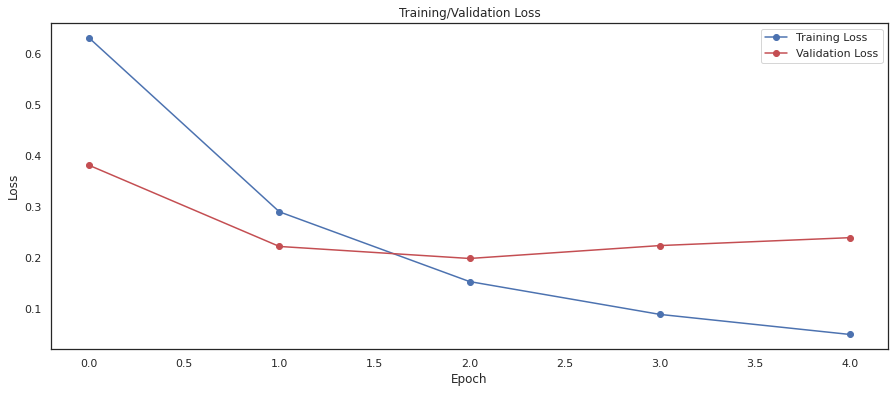

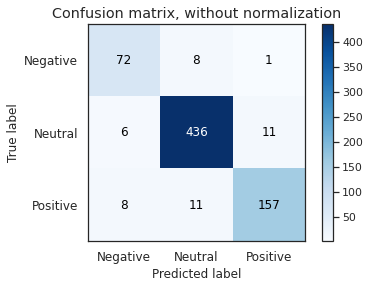

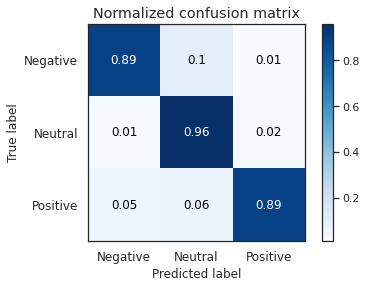

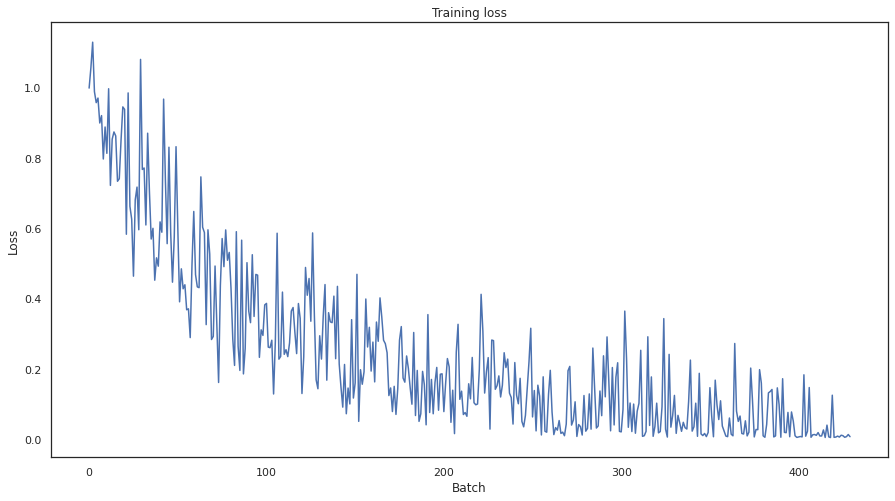

Accuracy: 0.93661972, f1: 0.91092427



In [89]:
# Re-train the model with all Train set and validate on Test set

# Input Data
x_test = np.array(test['sentence'])
y_test = np.array(test['label'].astype(int).values)

# Make sure to load the pre-trained model every time
albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

acc, f1, y_test_pred = \
        train_transformer(albert_model, x_train, y_train, x_test, y_test, \
                          learning_rate, num_epochs, batch_size, patience, warm_up_proportion, max_grad_norm, max_seq_length)
    
print(('Accuracy: %.8f, f1: %.8f\n' % (acc, f1)))

In [90]:
result_df.loc['D2: ALBERT'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,F1
A: Lexicon,0.6536,0.4683
B: Tfidf,0.8203,0.7163
C1: LSTM,0.7672,0.7184
C2: LSTM+GloVe,0.7891,0.7169
D1: BERT,0.9521,0.9346
D2: ALBERT,0.9366,0.9109


# Final Result

In [92]:
# If disconnected after the training complete, just recreate the result_df rather than running the training again...
disconnected = False
if disconnected:
    result_df = pd.DataFrame(columns=['Accuracy', 'F1'], index=['A: Lexicon', 'B: Tfidf', 'C: LSTM', 'D: LSTM+GloVe', 'E: BERT', 'F: ALBERT'])
    result_df.loc['A: Lexicon'] = (0.6522,0.4506)
    result_df.loc['B: Tfidf'] = (0.8145,0.7195)
    result_df.loc['C1: LSTM'] = (0.8185,0.7657)
    result_df.loc['C2: LSTM+GloVe'] = (0.8051,0.7415)
    result_df.loc['D1: BERT'] = (0.9493,0.9267)
    result_df.loc['D2: ALBERT'] = (0.9067,0.8849)


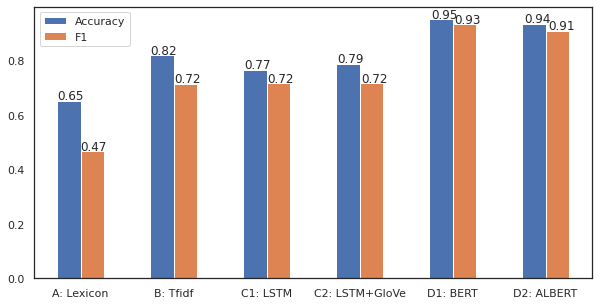

In [94]:
ax = result_df.plot.bar(rot=0, figsize=(10,5))

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

# Save Data

In [95]:
def save_data(df, file_name, dir_name=output_dir):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [96]:
# Save text data
save_data(train_df, 'finphrase_result_df')